# **Tutorial** : create your own base map from A to Z with CartAGen, from IGN's BD TOPO
![Alt text](https://assets-global.website-files.com/63483ad423421bd16e7a7ae7/63a16770a97b930a84c77f00_voyager-positron.png)

_Source : https://carto.com/blog/new-voyager-basemap_ \
Press **`space bar`** to show next slide 

- 🙋 **For whom ?** : 
    - cartographers wishing to obtain a **customized background map** to enhance their cartographic projects, with an **open source** solution
    - **national mapping institutes** and other organizations wishing to discover the **cartographic generalization possibilities** offered by the CartAGen tool
    - anyone who wants to understand how **topographic maps** are made!

Press **`space bar`** to show next message

- ❓ **What is CartAGen ?** :
    - an **open source Python library** made by **IGN** (i.e the french national mapping agency) researchers
    - a tool to carry out cartographic generalization processes and **automate** them
    - a **QGIS plugin** to use the Python library in a GIS environment  
    
Press **`space bar`** and **`scroll down`** to show next message 

- 📗 **How to use this Notebook ?** : 
    - a Notebook is a document that mixes **markdown cells** (i.e. cells with formatted text like this one) and **code cells**, which you can modify and execute at will
    - it comes with a **sample data set** on which you can **test** the various features of the CartAGen python library
    - you can import your **own data** and run the code cells of this Notebook, or use the CartAGen tool in **another environment** (QGIS or python script)
    
Press **`right arrow`** to show next slide and start part 0, or press **`space bar`** to show sub-slide and see useful links

- 🔗 **Useful links** : 
    - [Repository of the library](https://github.com/LostInZoom/cartagen4py?tab=readme-ov-file)
    - [Repository of the QGIS Plugin](https://github.com/LostInZoom/cartagen-qgis)
    - [CartAGen documentation](https://cartagen4py.readthedocs.io/en/latest/index.html)
    - [IGN's BD TOPO](https://geoservices.ign.fr/bdtopo)

_by Paul Bourcier, 2024 - CC-BY-SA 4.0_

Press **`space bar`** to show next slide, press **`shift + space bar`** to go backward\
**`Click`** question mark icon to show other shortcuts

## ⚙️ **Part 0 :** Preparing the working environment

Press **`space bar`** to show code cell, then press **`shift + enter`** to execute it\
**`*`** symbol means code output is loading

In [2]:
# 0.1/ Importing libraries

from matplotlib import pyplot as plt # for ploting results, especially maps
import cartagen as cg # the main library, containing cartographic generalization algorithms
import geopandas as gp # used to import and manipulate geographic data
import pandas as pd # used to concatenate datas
import ipywidgets # creation of interactive plots
import os # navigation within the environnement
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar # adding scalebar to the maps
import matplotlib.colors as matcol # generating color palettes
from matplotlib.figure import Figure # Plot generation
from mpl_toolkits.axisartist.axislines import Subplot # Plot generation
from shapely.geometry import Polygon, MultiPolygon # Create and manipulate geometries
from shapely.wkt import loads # Create and manipulate geometries
from shapely import intersects
from shapely.ops import linemerge
from tqdm.notebook import tqdm # Creating loading bar
from time import sleep # Creating loading bar
import progressbar # Creating loading bar
import numpy as np # Using mathematical operations in Python
import re # regex
from IPython.display import clear_output, Image # used to delete widgets

import warnings # Remove warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*GeoDataFrame you are attempting to plot is empty.*") # Remove user warning 
warnings.filterwarnings("ignore", category=UserWarning, message=".*CRS not set for some of the concatenation inputs.*.")

**0.2/** Configuring screen for figure size

In [3]:
# Configuring screen for figure size
conv = 0
SCREEN = 0
def cal_screen(size):
    global conv
    global SCREEN
    print("Configure the picture so it fits a real credit card :")
    display(Image('data/CreditCard.png', width=size))
    conv = 1/100*(size/3.37007874)

    SCREEN = {
    '1:25000':(2.45*conv,2.45*conv), 
    '1:10000':(6.2*conv,6.2*conv),
    '1:7500':(8.15*conv,8.15*conv),
    '1:5000':(15.26*conv,15.26*conv)}

ipywidgets.interact(cal_screen, size = ipywidgets.IntSlider(value = 300,min=0,max=600,step=1,continuous_update = False))

interactive(children=(IntSlider(value=300, continuous_update=False, description='size', max=600), Output()), _…

<function __main__.cal_screen(size)>

💬 Note : sometimes the **display resolution** of your screen or browser is more (or less) than 100 %, which can result in wrong scale value when displaying maps.

## 🗺 **Part 1 :** What is cartographic generalisation and why do we need it ?

### **1.1/** Building a basemap from IGN's BD TOPO
BD TOPO is an IGN product consisting of a **vector database** representing all the features and infrastructures of the French territory (buildings, roads, administrative boundaries, etc.), with **metric precision**. 
It is therefore a good basis for the creation of a base map. 

Let's start by importing part of this database and customizing its **symbolization**. 

**1.1.1/** Importing the data of the extract (1 file per type of feature)

In [4]:
# Importing the data of the extract (1 file per type of feature)
widgets = [
    '', progressbar.Percentage(), ' ',  
    progressbar.Bar(marker='🟩', left='', right='                                                  ', width = 1) 
]


files = os.listdir('data/data_fd_carte_1')
layer_names = []
layer_list = []

with progressbar.ProgressBar(max_value=len(files),widgets=widgets) as bar:
    for file in files:
        data = gp.read_file(f'data/data_fd_carte_1/{file}')
        layer_list.append(data)
        match = re.match(r'^(.*)\.geojson', file)
        layer_names.append(match.group(1))
        bar.update(files.index(file))

datas = {name: gdf for name, gdf in zip(layer_names, layer_list)}

if len(layer_list) == len(os.listdir('data/data_fd_carte_1')):
    print("✅ successful import")
else:
    print("❌ import failed")

100% 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩                                                  


✅ successful import


**1.1.2/** Display the datas without setting up symbolization

100% 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩                                                  


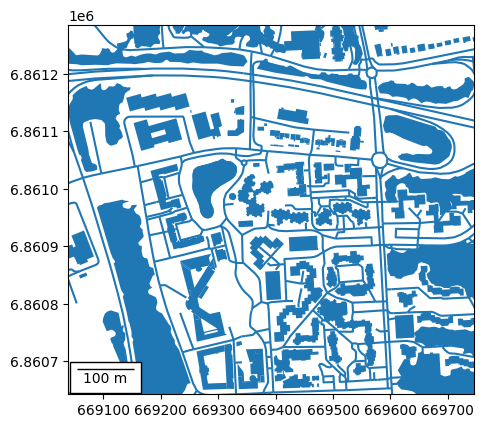

In [4]:
# Plotting the datas without setting up symbolization

ax = datas['gdf_trainline'].plot()
plt.xlim(669039, 669745)
plt.ylim(6860642, 6861286)	

scalebar = AnchoredSizeBar(ax.transData,
                           100,  
                           '100 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
ax.add_artist(scalebar)
with progressbar.ProgressBar(max_value=len(datas),widgets=widgets) as bar:
    for name, gdf in datas.items():
        gdf.plot(ax = ax)
        bar.update(1)

💬 This Notebook is meant to be **interactive** (beyond code modifications) : after **running** a code cell, you will often be able to **change** algorithm parameters or figure settings, thanks to **buttons**. Let's try interactivity on **road symbology**. You will be able to change roads **color** and **width** depending on their 'importance' attribute. You can also change the **size** of the figure (figure size button) and **revert** your changes.

**1.1.3/** Interactively setting up symbolization for roads

In [ ]:
# Interactively setting up symbolization for roads
size = {'small':(5,5),'medium':(10,10), 'large':(15,15)}
roads_sorted = [] # Creation of a list containing a gdf by degree of road importance 
for i in range(2,len(datas['gdf_road'].importance.unique())+2):
    roads_sorted.append(datas['gdf_road'][(datas['gdf_road'].importance == str(i))]) 

grid = ipywidgets.GridspecLayout(5, 6)
grid[0,0] = ipywidgets.ColorPicker(concise=False,description='color road lvl 2',value='#ffffff',style= {'description_width': 'initial'})
grid[1,0] = ipywidgets.ColorPicker(concise=False,description='color road lvl 3',value='#ffffff',style= {'description_width': 'initial'})
grid[2,0] = ipywidgets.ColorPicker(concise=False,description='color road lvl 4',value='#ffffff',style= {'description_width': 'initial'})
grid[3,0] = ipywidgets.ColorPicker(concise=False,description='color road lvl 5',value='#ffffff',style= {'description_width': 'initial'})
grid[4,0] = ipywidgets.ColorPicker(concise=False,description='color road lvl 6',value='#ffffff',style= {'description_width': 'initial'})
grid[0,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width road lvl 2', continuous_update=False,style= {'description_width': 'initial'})
grid[1,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width road lvl 3', continuous_update=False,style= {'description_width': 'initial'})
grid[2,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width road lvl 4', continuous_update=False,style= {'description_width': 'initial'})
grid[3,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width road lvl 5', continuous_update=False,style= {'description_width': 'initial'})
grid[4,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width road lvl 6', continuous_update=False,style= {'description_width': 'initial'})
grid[0,2] = ipywidgets.Dropdown(options=['small','medium', 'large'], value='medium', description='figure_size')
grid[1,2] = ipywidgets.Button(description='reset',icon='undo')

def plt_roads(col_2, col_3, col_4, col_5, col_6, width_2, width_3, width_4, width_5, width_6, figure_size = 'medium'): # Function that plot each road and prepare arguments for interaction
    global size
    
    ax = datas['gdf_road'].plot(alpha = 0,figsize=size[figure_size])
    plt.xlim(669039, 669745)
    plt.ylim(6860642, 6861286)
    scalebar = AnchoredSizeBar(ax.transData,
                           100,  
                           '100 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
    ax.axes.get_yaxis().set_visible(False)

    list_col = [col_2, col_3, col_4, col_5, col_6]
    list_width = [width_2, width_3, width_4, width_5, width_6]

    with progressbar.ProgressBar(max_value=len(datas['gdf_road'].importance.unique()),widgets=widgets) as bar:
        for i in reversed(range(2,len(datas['gdf_road'].importance.unique())+2)):
            roads_sorted[i-2].plot(ax = ax, color = "black", linewidth = list_width[i-2]+1,alpha = 0.5) 
            roads_sorted[i-2].plot(ax = ax, color = list_col[i-2], linewidth = list_width[i-2])
            bar.update(1)
                                 
    def reset(b):
        grid[0,0].value = '#ffffff'
        grid[1,0].value = '#ffffff'
        grid[2,0].value = '#ffffff'
        grid[3,0].value = '#ffffff'
        grid[4,0].value = '#ffffff'
        grid[0,1].value = 0.6
        grid[1,1].value = 0.6
        grid[2,1].value = 0.6
        grid[3,1].value = 0.6
        grid[4,1].value = 0.6

    grid[1,2].on_click(reset)        

out_road_symbo = ipywidgets.interactive_output(plt_roads, {'col_2':grid[0,0], 'col_3':grid[1,0], 'col_4':grid[2,0], 'col_5':grid[3,0], 
'col_6':grid[4,0], 'width_2':grid[0,1], 'width_3':grid[1,1], 'width_4':grid[2,1], 'width_5':grid[3,1], 'width_6':grid[4,1], 'figure_size':grid[0,2]})# Calls up the function for interactively defining road width and color 

display(grid,out_road_symbo)

💬 Since there's **a lot** of symbolization functionality to configure, let's **fast-forward** and see what our **example basemap** might look like :

**1.1.4/** Display example basemap with symbology

In [ ]:
# Displaying example basemap with symbology

# Dividing roads according to their type and importance
roads_sorted = []
for i in range(2,len(datas['gdf_road'].importance.unique())+2):
    roads_sorted.append(datas['gdf_road'][(datas['gdf_road'].importance == str(i)) & (datas['gdf_road'].nature != "Chemin") 
                                                                    & (datas['gdf_road'].nature != "Sentier") 
                                                                    & (datas['gdf_road'].nature != "Route empierrée")]) 

gdf_paths = datas['gdf_road'][(datas['gdf_road'].nature == "Chemin") | (datas['gdf_road'].nature == "Sentier") # Creation of a gdf containing paths/trail
                                                         | (datas['gdf_road'].nature == "Route empierrée")] 

# Preparing color palettes for roads and buildings
list_col_roads = ['#d58c88','#d5b188','#d5c788','#ccd588','#b4d588','#95d588']
col_buildings = matcol.LinearSegmentedColormap.from_list('ColBuildings',
                                                        ['#9c9c9c','#9c9c9c','#bf9eb1','#9c9c9c','#fff3b0','#9c9c9c','#9c9c9c','#9fbfa1'])

# Setting up the map
ax = datas['gdf_road'].plot(alpha = 0, figsize=(8,8))
plt.xlim(669039, 669745)
plt.ylim(6860642, 6861286)	
scalebar = AnchoredSizeBar(ax.transData,
                           100,  
                           '100 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
ax.add_artist(scalebar)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Displaying the different features
with progressbar.ProgressBar(max_value=15,widgets=widgets) as bar:
    for i in range(1):
        datas['gdf_water1'].plot(ax = ax, color = "#b3d9ff", zorder = 0) 
        bar.update(1)
        gdf_paths.plot(ax =ax, color = "#2aae5f", linewidth = 0.8, linestyle='dashed', alpha = 0.5)
        bar.update(1)
            
        for i in reversed(range(2,len(datas['gdf_road'].importance.unique())+2)): 
            roads_sorted[i-2].plot(ax = ax, color = "grey", linewidth = 6.5/i ,alpha = 0.5)
            bar.update(1)
            roads_sorted[i-2].plot(ax = ax, color = list_col_roads[i-2], linewidth = 5/i)
            bar.update(1)

        datas['gdf_building'].plot(ax = ax, cmap = col_buildings, column = "usage_1", zorder = 2) 
        bar.update(1)

        datas['gdf_vegetation'].plot(ax = ax, color = "#d1ffba", zorder = 0)
        bar.update(1)
       


💬 As you can see, by configuring the **symbolization** of our map's elements, we obtain a satisfactory basemap. 

However, the **legibility** of the map tends to **diminish** as the scale decreases (and the number of elements displayed increases)...

**Note :** This basemap could be improved by adding effects to the elements, such as **shading**. 
It should be noted that GIS environment offers more **user-friendly** tools for carrying out symbolization processes. 

### **1.2/** The issue of scale 
BD TOPO contains **many** different elements. As the scale (i.e. the mathematical relationship between the size of features on the map and reality) **decreases**, the number of features displayed **increases**. Sometimes there's too much information on the map. Here's an example :  

![Alt text](https://raw.githubusercontent.com/gowestmen/images/main/bd_topo_seine_et_marne.png)


Here we've displayed the BD TOPO at a **regional scale** without configuring the symbology. The result is **not readable**. The processes of transforming a map to make it readable are called **map generalization**. They can be carried out in different ways:
- by **selecting** the elements to be displayed
- parameterizing **symbology** (reducing road width, for example)
- by performing **transformations on the entities** themselves -> that is what CartAGen is made for ! 

Let's make the same basemap on a **smaller scale**, to see to what extent entity selection and symbology settings are sometimes **not enough** to get a good result.

**1.2.1/** Importing the data of the second extract 

In [ ]:
# Importing the data of the second extract 

files = os.listdir('data/data_fd_carte_2')

layer_names_2 = []
layer_list_2 = []

with progressbar.ProgressBar(max_value=len(files),widgets=widgets) as bar:
    for file in files:
        data = gp.read_file(f'data/data_fd_carte_2/{file}')
        layer_list_2.append(data)
        match = re.match(r'^(.*)\.geojson', file)
        layer_names_2.append(match.group(1))
        bar.update(files.index(file))
        
    datas_2 = {name: gdf for name, gdf in zip(layer_names_2, layer_list_2)}

if len(layer_list_2) == len(os.listdir('data/data_fd_carte_2')):
    print("✅ successful import")
else:
    print("❌ import failed")

**1.2.2/** Display the smaller scale base map

In [ ]:
# Dividing roads according to their type and importance
gdf_roads_2 = []
for i in range(1,len(datas_2['gdf_road'].importance.unique())+2):
    gdf_roads_2.append(datas_2['gdf_road'][(datas_2['gdf_road'].importance == str(i)) & (datas_2['gdf_road'].nature != "Chemin") 
                                                                    & (datas_2['gdf_road'].nature != "Sentier") 
                                                                    & (datas_2['gdf_road'].nature != "Route empierrée")])      
gdf_paths_2 = datas_2['gdf_road'][(datas_2['gdf_road'].nature == "Chemin") | (datas_2['gdf_road'].nature == "Sentier") # Creation of a gdf containing paths/trail
                                                         | (datas_2['gdf_road'].nature == "Route empierrée")] 

# Preparing color palettes for roads and buildings
list_col_roads = ['#e19494','#e6a998','#e8baa1','#ffffff','#ffffff','#ffffff']
col_buildings = matcol.LinearSegmentedColormap.from_list('ColBuildings',
                                                        ['#111111','#111111','#bf9eb1','#111111','#9f9dbf','#111111','#111111','#9fbfa1'])

# Setting up the map
ax = datas_2['gdf_road'].plot(alpha = 0, figsize = (17,17))
plt.xlim(665361, 675157)
plt.ylim(6858025, 6863813)	
scalebar = AnchoredSizeBar(ax.transData,
                           1000,  
                           '1000 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
ax.add_artist(scalebar)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Displaying the different features
with progressbar.ProgressBar(max_value=22,widgets=widgets) as bar:
    for i in range(1):
        datas_2['gdf_water1'].plot(ax = ax, color = "#b3d9ff", zorder = 0) 
        bar.update(1)
        sleep(0.1)
        datas_2['gdf_water2'].plot(ax = ax, color = "#b3d9ff", zorder = 0) 
        bar.update(2)
        sleep(0.1)
        gdf_paths_2.plot(ax =ax, color = "#2aae5f", linewidth = 0.8, linestyle='dashed', alpha = 0.5) 
        bar.update(3)
        sleep(0.1)
        datas_2['gdf_building'].plot(ax = ax, cmap = col_buildings, column = "usage_1", zorder = 2) 
        bar.update(4)
        sleep(0.1)
        for i in reversed(range(1,len(datas_2['gdf_road'].importance.unique())+1)): 
            gdf_roads_2[i-1].plot(ax = ax, color = "black", linewidth = 6.2/i) 
            bar.update(10)
            sleep(0.1)
            gdf_roads_2[i-1].plot(ax = ax, color = list_col_roads[i-1], linewidth = 5.1/i)
    
          
        datas_2['gdf_vegetation'].plot(ax = ax, color = "#d1ffba", zorder = 0) 
        bar.update(17)
        sleep(0.1)
        datas_2['gdf_forest'].plot(ax = ax, color = "#098a2e", zorder = 0, alpha = 0.3) 
        bar.update(18)
        sleep(0.1)
        datas_2['gdf_commune'].plot(ax = ax, facecolor = "None", edgecolor = "grey", linestyle='dashed', zorder = 3) 
        bar.update(19)
        sleep(0.1)
        datas_2['gdf_trainline'].plot(ax = ax, color = "grey", linewidth = 1, alpha = 0.5) 
        bar.update(20)
        sleep(0.1)
        datas_2['gdf_sportfield'].plot(ax = ax, color = "#9fbfa1") 
        bar.update(21)
        sleep(0.1)
        datas_2['gdf_graveyard'].plot(ax = ax, color = "grey", alpha = 0.7) 
        bar.update(22)
        sleep(0.1)

💬 This map shows elements of the BD TOPO at **1:25000** scale (approximatly). Compared with our first basemap, there are **much** more elements displayed. In addition, the map's legibility is **altered**, especially with regard to the following aspects : 
- many buildings (especially houses) are **too small** and produce **noise** in map legibility
- some roads, especially paths, are **too complex in shape**, so that they look more like a mass than a line


To solve these **problems**, it's not enough to modify the **symbology** or to **select** the elements to be represented. Let's take the example of paths :
- we can't really improve legibility by changing the symbology, since the **path width** is already quite small
- not displaying paths at all seems like a bad solution (depending on cartographer's needs), as they provide **useful landmarks** on the map, especially in forests.

➡️ To enhance our base map, we need to perform **transformations** on the features. Let's use CartAGen to build a cartographic generalization **workflow** !

## 🏗 **Part 2 :** Cartographic generalisation workflow for basemap creation

💬 As mentioned above, the **needs** for cartographic generalization depend on the **scale** of the intended rendering (and therefore the number of elements displayed).  
But these needs also depend on the map's **objectives**. For example, if cartographers want to display a lot of **thematic datas** on their basemap, it's in their interest to use one with a **minimalist** appearance, to stylize their map without detracting from the legibility of the thematic datas.

In other words, there isn't just one "good" generalization workflow for a given result, but several, depending on the **needs and subjectivity** of the cartographers.

Thus, this section will present different **workflows** for cartographic generalization, leading to **more or less** generalized results. 

As some map generalization algorithms can be **quite long** to run (especially on buildings), we will present our results on a **small area** in this Notebook, in order to keep loading time acceptable.

### **2.1/** Selection and symbolization
💬 Let's start by **selecting** the elements we want to display and setting up the desired **symbology** - the **first steps** in a cartographic generalization process.

Depending on the **level of generalization** you wish to achieve, your choices in terms of selection and symbolization will **change** :
- highly generalized : keep only the **main elements** and set a **wide** width for linear elements
- slightly generalized : retain **most elements** and set a **narrow** width for linear elements

**2.1.1/** Import and prepare third data extract

In [5]:
# Import and prepare third data extract
files = os.listdir('data/data_fd_carte_3')
layer_names_3 = []

layer_list_3 = []
with progressbar.ProgressBar(max_value=len(files),widgets=widgets) as bar:
    for file in files: # Loading data files
        data = gp.read_file(f'data/data_fd_carte_3/{file}')
        layer_list_3.append(data)
        match = re.match(r'^(.*)\.geojson', file)
        layer_names_3.append(match.group(1))
        bar.update(files.index(file))
datas_3 = {name: gdf for name, gdf in zip(layer_names_3, layer_list_3)} # Storing datas in a dictionary

def multipolygon_to_polygon(geom): # function that transform MultiPolygon geometry to Polygon
    if isinstance(geom, MultiPolygon):
        return geom.geoms[0]
    return geom

for gdf in datas_3: # Only keep useful columns and perform geometry transformations
    if 'usage_1' in datas_3[gdf].columns:
        datas_3[gdf] = datas_3[gdf][["cleabs","usage_1","geometry"]]
        datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].apply(multipolygon_to_polygon)
        datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].force_2d()
        
    elif 'nature' in datas_3[gdf].columns and 'importance' in datas_3[gdf].columns:
        datas_3[gdf] = datas_3[gdf][["cleabs","nature","importance","geometry"]]
        datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].force_2d()
        
    else:
        if datas_3[gdf].geometry[0].geom_type != 'LineString' :
            datas_3[gdf] = datas_3[gdf][["cleabs","geometry"]]
            datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].apply(multipolygon_to_polygon)
            datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].force_2d()
        else:
            datas_3[gdf] = datas_3[gdf][["cleabs","geometry"]]
            datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].force_2d()

if len(layer_list_3) == len(os.listdir('data/data_fd_carte_3')): # Print success/failure message
    print("✅ successful import")
else:
    print("❌ import failed")

100% 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩                                                  


✅ successful import


**2.1.2/** Select elements to display

In [6]:
# Select elements to display
grid = ipywidgets.GridspecLayout(7, 8) # Creating grid layout for our buttons

ROAD_TYPE = {
    '0':'one side road',
    '1':'two side road',
    '2':'roundabout',
    '3':'trail',
    '4':'rocky road'}
ROAD_TYPE_FR = {
    '0':'Route à 1 chaussée',
    '1':'Route à 2 chaussées',
    '2':'Rond-point',
    '3':'Sentier',
    '4':'Route empierrée'}
BUILDING_TYPE = {
    '0':'residential',
    '1':'annex',
    '2':'commercial and services',
    '3':'religious',
    '4':'agricultural',
    '5':'sport facility',
    '6':'other'}
BUILDING_TYPE_FR = {
    '0':'Résidentiel',
    '1':'Annexe',
    '2':'Commercial et services',
    '3':'Religieux',
    '4':'Agricole',
    '5':'Sportif',
    '6':'Indifférencié'}

for i in range(5): # buttons for road selection according to importance level and type
    grid[i,0] = ipywidgets.Checkbox(value=True, description=f"road importance lvl {i+2}")
    grid[i,1] = ipywidgets.Checkbox(value=True, description=ROAD_TYPE[f"{i}"])  
for i in range(7): # buttons for building selection according to type
    grid[i,2] = ipywidgets.Checkbox(value=True, description=BUILDING_TYPE[f"{i}"])
for i in range(1): # buttons for other features
    grid[0,3] = ipywidgets.Checkbox(value=True, description='communes boundaries')
    grid[0,4] = ipywidgets.Checkbox(value=True, description='sports field')
    grid[0,5] = ipywidgets.Checkbox(value=True, description='trainline')
    grid[0,6] = ipywidgets.Checkbox(value=True, description='vegetation zone')
    grid[0,7] = ipywidgets.Checkbox(value=True, description='water')
    grid[3,3] = ipywidgets.Dropdown(options=['1:25000','1:10000', '1:7500', '1:5000'], value='1:7500', description='scale')

selected_data = 0 # Declaring the variable that will store the selected datas

def plt_and_select(road_importance_2,road_importance_3,road_importance_4,road_importance_5,road_importance_6,
                   one_side_road, two_side_road, roundabout, trail, rocky_road, 
                   residential, annex, commercial_services, religious, agricultural, sport_facility, other,
                   communes_boundaries,
                   sports_field,
                   trainline,
                   vegetation_zone,
                   water,scale):
    # Setting up the map
    global SCREEN
    global list_generalized
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    scalebar = AnchoredSizeBar(ax.transData,
                           250,  
                           '250 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    global selected_data
    selected_data = datas_3.copy()
    
    for i in range(1): # Filtering storage variable on interactively selected features
        if road_importance_2 != True:          
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "2")]
        
        if road_importance_3 != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "3")]

        if road_importance_4 != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "4")]

        if road_importance_5 != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "5")]

        if road_importance_6 != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "6")]

        if one_side_road != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Route à 1 chaussée")]

        if two_side_road != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Route à 2 chaussées")]

        if roundabout != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Rond-point")]

        if trail != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Sentier")]

        if rocky_road != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Route empierrée")]
        
        if residential != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Résidentiel")]

        if annex != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Annexe")]

        if commercial_services != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Commercial et services")]

        if religious != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Religieux")]

        if agricultural != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Agricole")]

        if sport_facility != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Sportif")]

        if other != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Indifférencié")]

        if communes_boundaries != False:
            selected_data['gdf_commune'].plot(ax= ax, facecolor = 'None', edgecolor = "grey")
        else:
            selected_data['gdf_commune'] = selected_data['gdf_commune'].iloc[0:0]

        if sports_field != False:
            selected_data['gdf_sportfield'].plot(ax= ax, facecolor = "green")
        else:
            selected_data['gdf_sportfield'] = selected_data['gdf_sportfield'].iloc[0:0]

        if trainline != False:
            selected_data['gdf_trainline'].plot(ax= ax, color = "black")
        else:
            selected_data['gdf_trainline'] = selected_data['gdf_trainline'].iloc[0:0]
        
        if vegetation_zone != False:
            selected_data['gdf_vegetation'].plot(ax= ax, facecolor = "green")
        else:
            selected_data['gdf_vegetation'] = selected_data['gdf_vegetation'].iloc[0:0]

        if water != False:
            selected_data['gdf_water'].plot(ax= ax, facecolor = "blue")
        else:
            selected_data['gdf_water'] = selected_data['gdf_water'].iloc[0:0]

    with progressbar.ProgressBar(max_value=17,widgets=widgets) as bar:
        for i in range(5): # Displaying roads
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i+2}")].plot(ax = ax, color = "grey", linewidth = 4*(1/(i+1)))

            selected_data['gdf_road'][(selected_data['gdf_road'].nature == ROAD_TYPE_FR[f"{i}"])].plot(ax = ax, color = "grey", linewidth = 0.5)
            bar.update(i)   
        for i in range(7): # Displaying buildings
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == BUILDING_TYPE_FR[f"{i}"])].plot(ax = ax, color = list(np.random.choice(range(20), size=3)/256))
            bar.update(i+5)
    
    list_generalized = [selected_data['gdf_road'].copy()]
out = ipywidgets.interactive_output(plt_and_select, {'road_importance_2':grid[0,0],'road_importance_3':grid[1,0], 'road_importance_4':grid[2,0], 'road_importance_5':grid[3,0], 'road_importance_6':grid[4,0],
                                                     'one_side_road':grid[0,1],'two_side_road':grid[1,1], 'roundabout':grid[2,1], 'trail':grid[3,1], 'rocky_road':grid[4,1],
                                                     'residential':grid[0,2],'annex':grid[1,2],'commercial_services':grid[2,2],'religious':grid[3,2],'agricultural':grid[4,2],'sport_facility':grid[5,2],'other':grid[6,2],
                                                     'communes_boundaries':grid[0,3],
                                                     'sports_field':grid[0,4],
                                                     'trainline':grid[0,5],
                                                     'vegetation_zone':grid[0,6],
                                                     'water':grid[0,7],
                                                     'scale':grid[3,3]})   
display(grid, out)

GridspecLayout(children=(Checkbox(value=True, description='road importance lvl 2', layout=Layout(grid_area='wi…

Output()

**2.1.3/** Set up symbology

In [7]:
# Set up symbology
gdf_bckgrnd = gp.GeoDataFrame(geometry=gp.GeoSeries([loads('Polygon ((668199 6860870, 669412 6860870, 669412 6860148, 668199 6860148, 668199 6860870))')]))

grid = ipywidgets.GridspecLayout(7, 9) # Creating grid layout for our button

for i in range(5): # Creating the buttons road color and width
    grid[i,0] = ipywidgets.ColorPicker(concise=False,description=f"color road lvl{i+2}",value='#111111',style= {'description_width': 'initial'})
    grid[i,1] = ipywidgets.FloatSlider(min=0.6, max=15.0, step=0.2, description=f'width road lvl {i+2}', continuous_update=False,style= {'description_width': 'initial'})
for i in range(7): # Creating the buildings color
    grid[i,2] = ipywidgets.ColorPicker(concise=False,description='color '+BUILDING_TYPE[f'{i}'],value='#111111',style= {'description_width': 'initial'})
for i in range(1): # buttons for other features
    grid[0,3] = ipywidgets.Checkbox(value=True, description='background on/off')
    grid[1,3] = ipywidgets.ColorPicker(concise=False, description='color background', value='#ffffff')
    grid[4,3] = ipywidgets.Dropdown(options=['1:25000','1:10000', '1:7500', '1:5000'], value='1:7500', description='scale')

    grid[0,4] = ipywidgets.ColorPicker(concise=False, description='color sports field', value='#111111',style= {'description_width': 'initial'})

    grid[0,5] = ipywidgets.ColorPicker(concise=False, description='color communes', value='#111111', style= {'description_width': 'initial'})
    grid[1,5] = ipywidgets.FloatSlider(min=0.6, max=15.0, step=0.2, description='width communes', continuous_update=False, style= {'description_width': 'initial'})

    grid[0,6] = ipywidgets.ColorPicker(concise=False, description='color trainline', value='#111111')
    grid[1,6] = ipywidgets.FloatSlider(min=0.6, max=15.0, step=0.2, description='width trainline', continuous_update=False, style= {'description_width': 'initial'})

    grid[0,7] = ipywidgets.ColorPicker(concise=False, description='color vegetation', value='#111111')

    grid[0,8] = ipywidgets.ColorPicker(concise=False, description='color water', value='#111111')

    SYMBO_PARAM = { # Declare variable that will store chosen values
        'road_col_2':'0',
        'road_col_3':'0',
        'road_col_4':'0',
        'road_col_5':'0',
        'road_col_6':'0',
        'road_width_2':0,
        'road_width_3':0,
        'road_width_4':0,
        'road_width_5':0,
        'road_width_6':0,  
        'residential_col' :'0',
        'annex_col' :'0',
        'com_serv_col' :'0',
        'religious_col' :'0',
        'agricultural_col' :'0',
        'sport_facility_col' :'0',
        'other_col' :'0',
        'bckgrnd_col' :'0',
        'sports_field_col' :'0',
        'communes_col' :'0',
        'communes_width' :'0',
        'trainline_col' :'0',
        'trainline_width' :'0',
        'vegetation_col' :'0',
        'water_col' :'0'}

def pick_symbo(col_road_2, col_road_3, col_road_4, col_road_5, col_road_6, # Function for interactively set up symbology
               width_road_2, width_road_3, width_road_4, width_road_5, width_road_6, 
               col_residential, col_annex, col_com_serv, col_religious, col_agricultural, col_sport_facility, col_other, 
               background_on_off, col_bckgrnd,
               col_sports_field,
               col_communes, width_communes,
               col_trainline, width_trainline,
               col_vegetation,
               col_water,
               scale):

    # Setting up the map
    global SCREEN          
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    scalebar = AnchoredSizeBar(ax.transData,
                           250,  
                           '250 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    global SYMBO_PARAM # Calling the dictionnary that will store parameters

    with progressbar.ProgressBar(max_value=18,widgets=widgets) as bar:
        for i in range(1):
            if grid[0,3].value == True:
                gdf_bckgrnd.plot(ax= ax, color = col_bckgrnd)
                SYMBO_PARAM['bckgrnd_col'] = grid[1,3].value
                grid[1,3].description = "col_bckgrnd"
            else:
                grid[1,3].description = "not selected"
            bar.update(1)  

            if not selected_data['gdf_vegetation'].empty:
                selected_data['gdf_vegetation'].plot(ax= ax, color = col_vegetation)
                SYMBO_PARAM['vegetation_col'] = grid[0,7].value
            else:
                grid[0,7].description = "not selected"
            bar.update(2)  

            if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "6")].empty:
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == "6")].plot(ax= ax, color = "#1f2232", linewidth = width_road_6+1, alpha = 0.5)
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == "6")].plot(ax= ax, color = col_road_6, linewidth = width_road_6)
                SYMBO_PARAM['road_col_6'] = grid[4,0].value
                SYMBO_PARAM['road_width_6'] = grid[4,1].value
            else:
                grid[4,0].description = "not selected"
                grid[4,1].description = "not selected"
            bar.update(3)  

            if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "5")].empty:
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == "5")].plot(ax= ax, color = "#1f2232", linewidth = width_road_5+1, alpha = 0.5)
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == "5")].plot(ax= ax, color = col_road_5, linewidth = width_road_5)
                SYMBO_PARAM['road_col_5'] = grid[3,0].value
                SYMBO_PARAM['road_width_5'] = grid[3,1].value
            else:
                grid[3,0].description = "not selected"
                grid[3,1].description = "not selected"
            bar.update(4)  

            if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "4")].empty:
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == "4")].plot(ax= ax, color = "#1f2232", linewidth = width_road_4+1, alpha = 0.5)
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == "4")].plot(ax= ax, color = col_road_4, linewidth = width_road_4)
                SYMBO_PARAM['road_col_4'] = grid[2,0].value
                SYMBO_PARAM['road_width_4'] = grid[2,1].value
            else:
                grid[2,0].description = "not selected"
                grid[2,1].description = "not selected"
            bar.update(5)   

            if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "3")].empty:
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == "3")].plot(ax= ax, color = "#1f2232", linewidth = width_road_3+1, alpha = 0.5)
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == "3")].plot(ax= ax, color = col_road_3, linewidth = width_road_3)
                SYMBO_PARAM['road_col_3'] = grid[1,0].value
                SYMBO_PARAM['road_width_3'] = grid[1,1].value
            else:
                grid[1,0].description = "not selected"
                grid[1,1].description = "not selected"
            bar.update(6)    

            if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "2")].empty:
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == "2")].plot(ax= ax, color = "#1f2232", linewidth = width_road_2+1, alpha = 0.5)
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == "2")].plot(ax= ax, color = col_road_2, linewidth = width_road_2)
                SYMBO_PARAM['road_col_2'] = grid[0,0].value
                SYMBO_PARAM['road_width_2'] = grid[0,1].value
            else:
                grid[0,0].description = "not selected"
                grid[0,1].description = "not selected"
            bar.update(7)   

            if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Résidentiel")].empty:
                selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Résidentiel")].plot(ax= ax, color = col_residential)
                SYMBO_PARAM['residential_col'] = grid[0,2].value
            else:
                grid[0,2].description = "not selected"
            bar.update(8)  

            if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Annexe")].empty:
                selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Annexe")].plot(ax= ax, color = col_annex)
                SYMBO_PARAM['annex_col'] = grid[1,2].value
            else:
                grid[1,2].description = "not selected"
            bar.update(9) 

            if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Commercial et services")].empty:
                selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Commercial et services")].plot(ax= ax, color = col_com_serv)
                SYMBO_PARAM['com_serv_col'] = grid[2,2].value
            else:
                grid[2,2].description = "not selected"
            bar.update(10) 

            if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Religieux")].empty:
                selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Religieux")].plot(ax= ax, color = col_religious)
                SYMBO_PARAM['religious_col'] = grid[3,2].value
            else:
                grid[3,2].description = "not selected"
            bar.update(11) 

            if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Agricole")].empty:
                selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Agricole")].plot(ax= ax, color = col_agricultural)
                SYMBO_PARAM['agricultural_col'] = grid[4,2].value
            else:
                grid[4,2].description = "not selected"
            bar.update(12)  

            if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Sportif")].empty:
                selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Sportif")].plot(ax= ax, color = col_sport_facility)
                SYMBO_PARAM['sport_facility_col'] = grid[5,2].value
            else:
                grid[5,2].description = "not selected"
            bar.update(13) 

            if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Indifférencié")].empty:
                selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Indifférencié")].plot(ax= ax, color = col_other)
                SYMBO_PARAM['other_col'] = grid[6,2].value
            else:
                grid[6,2].description = "not selected"
            bar.update(14)     

            if not selected_data['gdf_sportfield'].empty:
                selected_data['gdf_sportfield'].plot(ax= ax, color = col_sports_field)
                SYMBO_PARAM['sports_field_col'] = grid[0,4].value
            else:
                grid[0,4].description = "not selected"
            bar.update(15) 

            if not selected_data['gdf_commune'].empty:
                selected_data['gdf_commune'].plot(ax= ax, facecolor = 'None', edgecolor = col_communes, linewidth = width_communes,linestyle='dashed', alpha = 0.25)
                SYMBO_PARAM['communes_col'] = grid[0,5].value
                SYMBO_PARAM['communes_width'] = grid[1,5].value
            else:
                grid[0,5].description = "not selected"
                grid[1,5].description = "not selected"
            bar.update(16)  

            if not selected_data['gdf_trainline'].empty:
                selected_data['gdf_trainline'].plot(ax= ax, color = col_trainline, linewidth = width_trainline)
                SYMBO_PARAM['trainline_col'] = grid[0,6].value
                SYMBO_PARAM['trainline_width'] = grid[1,6].value
            else:
                grid[0,6].description = "not selected"
                grid[1,6].description = "not selected"
            bar.update(17)  

            if not selected_data['gdf_water'].empty:
                selected_data['gdf_water'].plot(ax= ax, color = col_water)
                SYMBO_PARAM['water_col'] = grid[0,8].value
            else:
                grid[0,8].description = "not selected"
            bar.update(18)


out_2 = ipywidgets.interactive_output(pick_symbo,{'col_road_2':grid[0,0],'col_road_3':grid[1,0],'col_road_4':grid[2,0],'col_road_5':grid[3,0], 'col_road_6':grid[4,0],
                                                  'width_road_2':grid[0,1],'width_road_3':grid[1,1],'width_road_4':grid[2,1],'width_road_5':grid[3,1],'width_road_6':grid[4,1],
                                                  'col_residential':grid[0,2], 'col_annex':grid[1,2], 'col_com_serv':grid[2,2], 'col_religious':grid[3,2], 'col_agricultural':grid[4,2], 'col_sport_facility':grid[5,2], 'col_other':grid[6,2],
                                                  'background_on_off':grid[0,3], 'col_bckgrnd':grid[1,3],
                                                  'col_sports_field':grid[0,4],
                                                  'col_communes':grid[0,5], 'width_communes':grid[1,5],
                                                  'col_trainline':grid[0,6], 'width_trainline':grid[1,6],
                                                  'col_vegetation':grid[0,7],
                                                  'col_water':grid[0,8],
                                                  'scale':grid[4,3]})

display(grid, out_2)
scale = ipywidgets.Dropdown(options=['1:25000','1:10000', '1:7500', '1:5000'], value='1:7500', description='scale')

GridspecLayout(children=(ColorPicker(value='#111111', description='color road lvl2', layout=Layout(grid_area='…

Output()

💬 Now that we have done the **selection and symbolization**, it's time to dive into the **transformation** of our elements to complete our generalization processes.

The following sections will present proposed workflows for three **levels of generalization**. If the code cell relates to the targeted generalization level (indicated by the 🟡, 🟠 or 🔴 icon), then you should **run** this cell, otherwise you can **skip** it and go the next code cell.

- 🟡 **Slightly generalized :** most map details are preserved -> useful for large-scale maps (neighborhood) 
- 🟠 **Medium generalization :** intermediate between very generalized and lightly generalized rendering.
- 🔴 **Very generalized :** only the main map structures are preserved -> useful for small scales or minimalist basemaps

### **2.2/** Road generalization

Let's start by generalizing roads and paths so they have less details

**2.2.1/** 🟡🟠🔴 Using the "detect_dead_ends" algorithm on roads, to select small sections that decreazes road network legibility

In [ ]:
# 🟡🟠🔴 Step 1 : Using the "detect_dead_ends" algorithm on roads, to select small sections that decreazes road network legibility
de_col = matcol.LinearSegmentedColormap.from_list('de_col',['blue','red'])
count = -1
revert = ipywidgets.Button(description='revert',icon='undo')
outside_faces = ipywidgets.Checkbox(value=True, description="outside_faces")
scale = ipywidgets.Dropdown(options=['1:25000','1:10000', '1:7500', '1:5000'], value='1:7500', description='scale')

def plt_dtc_de(outside_faces, scale):
    global dead_ends
    global list_generalized
    global SCREEN
    global de_col
    global count 

    
    with progressbar.ProgressBar(max_value=9,widgets=widgets) as bar:
        try:
            dead_ends = cg.detect_dead_ends(list_generalized[count], outside_faces = outside_faces)
            bar.update(1)
        except IndexError:
            count += 1
            dead_ends = cg.detect_dead_ends(list_generalized[count], outside_faces = outside_faces)
            bar.update(1)

        # Setting up the map
        fig = plt.figure(figsize=SCREEN[scale])
        bar.update(2)
        ax = fig.add_subplot(111)
        bar.update(3)
        plt.xlim(668198, 669411)
        bar.update(4)
        plt.ylim(6860147, 6860869)
        bar.update(5)
        scalebar = AnchoredSizeBar(ax.transData, 250, '250 m', 'lower left', pad=0.5, color='black', frameon=True, size_vertical=1)
        bar.update(6)
        ax.add_artist(scalebar)
        bar.update(7)
        ax.axes.get_xaxis().set_visible(False)
        bar.update(8)
        ax.axes.get_yaxis().set_visible(False)

        # Display the result 
        bar.update(9)
        dead_ends.plot(ax = ax, column = 'deadend', cmap = de_col, linewidth = 0.8) 

def revert_fun(b):
    global count 
    global out_dtc_de
    count -= 1
    clear_output()
    out_dtc_de = ipywidgets.interactive(plt_dtc_de, outside_faces = outside_faces, scale = scale)
    display(out_dtc_de, revert)
revert.on_click(revert_fun)
 

out_dtc_de = ipywidgets.interactive(plt_dtc_de, outside_faces = outside_faces, scale = scale)
display(out_dtc_de, revert)

If you wish to see how the code of this algorithm works, press **`space bar`** and go to the next sub-slide.

**2.2.1'/** Detect dead end algorithm details

In [ ]:
import cartagen as cg

o_faces = True # storing algorithm parameter in a variable, used later on
de = cg.detect_dead_ends(list_generalized[count], outside_faces = o_faces) #list_generalized[count] is the road network in Geopandas GeoDataFrame format
 
de_col = matcol.LinearSegmentedColormap.from_list('de_col',['blue','red']) #declaring color palette for displaying result
de.plot(column = 'deadend', cmap = de_col) #using .plot() method on given GeoDataFrame, 
# and set up color according to section status (i.e dead end = True or False)

💬 This algorithm detect dead ends on each **"faces"** of the road network, i.e every zones **delimitated by roads**. As our data sample is **small**, we have a lot of **outside faces**, which tends to detect sections as dead ends while they are **main roads** cut in this data extract. 

In [ ]:
# Network faces calculation example
# Setting up the map
fig = plt.figure(figsize=SCREEN['1:7500'])
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)		
scalebar = AnchoredSizeBar(ax.transData,
                                    250,  
                                    '250 m',  
                                    'lower left',  
                                    pad=0.5,
                                    color='black',
                                    frameon=True,
                                    size_vertical=1)
ax.add_artist(scalebar)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

nf_geom = cg.network_faces(dead_ends.geometry,convex_hull=o_faces)
nf = gp.GeoDataFrame(geometry=gp.GeoSeries(nf_geom))

list_col_face = []
for i in nf.geometry:
    list_col_face.append((np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))

col_face = matcol.LinearSegmentedColormap.from_list('col_face',list_col_face)

nf.plot(ax=ax, cmap = col_face)
dead_ends.plot(ax=ax, color = 'black', linewidth = 0.8)

💬 Here is how are delimited the **network faces**. Only colorized part are faces taken in account for dead end **detection**

**2.2.2/** 🟡🟠🔴 Removing part of the roads considered as dead ends by using "eliminate_dead_ends" 

In [ ]:
# 🟡🟠🔴 Step 2 : Removing part of the roads considered as dead ends by using "eliminate_dead_ends"
count_intrn = 0
def plt_elim_de(length, klongest, scale = "1:7500"):
    global list_generalized
    global dead_ends
    global SCREEN
    global de_col
    global count
    global count_intrn
    
    with progressbar.ProgressBar(max_value=11,widgets=widgets) as bar:
        if 'dead_ends' not in globals():
            print("you must perform dead ends detection before collapsing them !")
            bar.update(1)
        else:
            count_intrn += 1
            bar.update(1)
            if count_intrn > 1:
                del(list_generalized[-1])
            generalized = cg.eliminate_dead_ends(dead_ends, length, klongest)
            bar.update(2)
            list_generalized.append(generalized)
            bar.update(3)
            
            # Setting up the map
            fig = plt.figure(figsize=SCREEN[scale])
            bar.update(4)
            ax = fig.add_subplot(111)
            bar.update(5)
            plt.xlim(668198, 669411)
            bar.update(6)
            plt.ylim(6860147, 6860869)
            bar.update(7)
            scalebar = AnchoredSizeBar(ax.transData,
                                                250,  
                                                '250 m',  
                                                'lower left',  
                                                pad=0.5,
                                                color='black',
                                                frameon=True,
                                                size_vertical=1)
            bar.update(8)
            ax.add_artist(scalebar)
            bar.update(9)
            ax.axes.get_xaxis().set_visible(False)
            bar.update(10)
            ax.axes.get_yaxis().set_visible(False)

            list_generalized[-1].plot(ax =ax, column = 'deadend', cmap = de_col, linewidth = 0.8)
            bar.update(11)
            
ipywidgets.interact(plt_elim_de, length = ipywidgets.FloatSlider(value = 20, min = 0,max = 500,step = 10,continuous_update=False),
                                                          klongest = True,
                                                          scale = ['1:25000','1:10000', '1:7500', '1:5000'])

💬 You can configure the **length threshold** to keep part of the dead ends (if you need details on your map). Using the keep_longest button allows you to keep the **main component** of dead end section, when it has a complex shape.

**2.2.2'/** Eliminate dead ends algorithm details

In [ ]:
generalized_de = cg.eliminate_dead_ends(dead_ends, length = 10, keep_longest = True)

generalized_de.plot(column = 'deadend', cmap = de_col, linewidth = 0.8) #Display result gdf with color according to section status (i.e dead end = True or False)

**2.2.3/** 🟡🟠🔴 Display intermediary results 

In [ ]:
# 🟡🟠🔴 Display intermediary results    

symbology_on_off = ipywidgets.Checkbox(value=True, description='symbology_on')

def bf_af_1(scale='1:7500', symbology_on= True):
    global SCREEN
    fig = plt.figure(figsize=SCREEN[scale])
    ax1 = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    plt.title("Before")	
    scalebar = AnchoredSizeBar(ax1.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax1.add_artist(scalebar)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    
    fig2 = plt.figure(figsize=SCREEN[scale])
    ax2 = fig2.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    plt.title("After")	
    scalebar = AnchoredSizeBar(ax2.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax2.add_artist(scalebar)	
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)	
    
    if scale == '1:25000':
        plt.subplots_adjust(hspace=0)
        
    if symbology_on == True:
        with progressbar.ProgressBar(max_value=19,widgets=widgets) as bar:
        
            for i in reversed(range(2,7)):
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)

                selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])


                list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)

                list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
                bar.update(5)

            for i in range(1):
                gdf_bckgrnd.plot(ax=ax2, color = SYMBO_PARAM['bckgrnd_col'])
                bar.update(6)
                gdf_bckgrnd.plot(ax=ax1, color = SYMBO_PARAM['bckgrnd_col'])
                bar.update(7)

                selected_data['gdf_trainline'].plot(ax=ax1, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
                bar.update(8)
                selected_data['gdf_trainline'].plot(ax=ax2, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
                bar.update(9) 

                selected_data['gdf_commune'].plot(ax=ax1, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
                bar.update(10)
                selected_data['gdf_commune'].plot(ax=ax2, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
                bar.update(11) 

                col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                                [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])    
                selected_data['gdf_building'].plot(ax=ax1, column = 'usage_1', cmap = col_buildings)
                bar.update(12)
                selected_data['gdf_building'].plot(ax=ax2, column = 'usage_1', cmap = col_buildings)
                bar.update(13)

                selected_data['gdf_sportfield'].plot(ax=ax1, color = SYMBO_PARAM['sports_field_col'])
                bar.update(14)
                selected_data['gdf_sportfield'].plot(ax=ax2, color = SYMBO_PARAM['sports_field_col'])
                bar.update(15)

                selected_data['gdf_vegetation'].plot(ax=ax1, color = SYMBO_PARAM['vegetation_col'])
                bar.update(16)
                selected_data['gdf_vegetation'].plot(ax=ax2, color = SYMBO_PARAM['vegetation_col'])
                bar.update(17)

                selected_data['gdf_water'].plot(ax=ax1, color = SYMBO_PARAM['water_col'])
                bar.update(18)
                selected_data['gdf_water'].plot(ax=ax2, color = SYMBO_PARAM['water_col'])
                bar.update(19)
             
    else:
        with progressbar.ProgressBar(max_value=2,widgets=widgets) as bar:
            for i in range(1):
                selected_data['gdf_road'].plot(ax =ax1, linewidth = 0.8)
                bar.update(1)
                list_generalized[len(list_generalized)-1].plot(ax =ax2, linewidth = 0.8)
                bar.update(2)
        
       
ipywidgets.interact(bf_af_1, scale = ['1:25000','1:10000', '1:7500', '1:5000'], symbology_on = True)

**2.2.4/** 🟡🟠🔴 Selecting the roundabouts to collapse using "detect_roundabouts" algorithm

In [ ]:
# 🟡🟠🔴 Step 3 : Selecting the roundabouts to collapse using "detect_roundabouts"
count = -1
area_threshold = ipywidgets.IntSlider(value=500, min=0, max=2500, step=10, continuous_update=False, style= {'description_width': 'initial'})
miller_index = ipywidgets.FloatSlider(value =0.95, min = 0,max = 1,step = 0.01,continuous_update=False)
revert1 = ipywidgets.Button(description='revert',icon='undo')

def plt_rb(area_threshold, miller_index, scale):
    with progressbar.ProgressBar(max_value=10,widgets=widgets) as bar:
        global list_generalized
        global rb
        global SCREEN
        global count
        global rb

        try:
            rb = cg.detect_roundabouts(list_generalized[count], area_threshold = area_threshold, miller_index = miller_index)
            bar.update(1)
        except IndexError:
            count += 1
            rb = cg.detect_roundabouts(list_generalized[count], area_threshold = area_threshold, miller_index = miller_index)
            bar.update(1)
        
        fig = plt.figure(figsize=SCREEN[scale])
        bar.update(2)
        ax = fig.add_subplot(111)
        bar.update(3)
        plt.xlim(668198, 669411)
        bar.update(4)
        plt.ylim(6860147, 6860869)
        bar.update(5)
        scalebar = AnchoredSizeBar(ax.transData,
                                                250,  
                                                '250 m',  
                                                'lower left',  
                                                pad=0.5,
                                                color='black',
                                                frameon=True,
                                                size_vertical=1)
        bar.update(6)
        ax.add_artist(scalebar)
        bar.update(7)
        ax.axes.get_xaxis().set_visible(False)
        bar.update(8)
        ax.axes.get_yaxis().set_visible(False)
        bar.update(9)
        
        # Display the result
        list_generalized[count].plot(ax =ax, linewidth = 0.8)
        if type(rb) == gp.geodataframe.GeoDataFrame:
            rb.plot(ax = ax, color = "orange") 
        bar.update(10)
        
def revert_fun(b):
    global count 
    global out_dtc_rb
    count -= 1
    clear_output()
    out_dtc_rb = ipywidgets.interactive(plt_rb, area_threshold = area_threshold, miller_index = miller_index, scale = scale)
    display(out_dtc_rb, revert1)
revert1.on_click(revert_fun)


out_dtc_rb = ipywidgets.interactive(plt_rb, area_threshold = area_threshold, miller_index = miller_index, scale = scale)
display(out_dtc_rb, revert1)

💬 **Miller index** give an idea of how **round** should be the feature to detect. The more it is close to **1**, the **rounder** detected features have to be.

**2.2.4'/** Detect roundabouts algorithm details

In [ ]:
roundabts = cg.detect_roundabouts(list_generalized[count], area_threshold = 4000, miller_index = 0.95) 

#Configuring display window
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)

if len(roundabts) > 0: 
    roundabts.plot(ax=ax, color = 'orange')
    list_generalized[count].plot(ax =ax, linewidth = 0.8)
else: 
    print("no roundabouts detected")

**2.2.5/** 🟡🟠🔴 Selecting the branching crossroads to collapse using "detect_branching_crossroads"

In [ ]:
# 🟡🟠🔴 Step 4 : Selecting the branching crossroads to collapse using "detect_branching_crossroads"
count = -1
revert2 = ipywidgets.Button(description='revert',icon='undo')
area_threshold_bc = ipywidgets.IntSlider(value =4000, min = 0,max = 10000,step = 100,continuous_update=False,style= {'description_width': 'initial'})
maximum_distance_area = ipywidgets.FloatSlider(value =0.5, min = 0,max = 1,step = 0.025,continuous_update=False, style= {'description_width': 'initial'})
allow_middle_node = ipywidgets.Checkbox(value=True, description="allow_middle_node ") 
middle_angle_tolerance = ipywidgets.FloatSlider(value =10, min = 0,max = 40,step = 1,continuous_update=False, style = {'description_width': 'initial'}) 
allow_single_4degree_node = ipywidgets.Checkbox(value=True, description="allow_single_4degree_node")

def plt_bc(area_threshold_bc, maximum_distance_area, allow_middle_node, middle_angle_tolerance, allow_single_4degree_node, scale = '1:7500'):
    with progressbar.ProgressBar(max_value=10,widgets=widgets) as bar:
        global bc 
        global list_generalized
        global SCREEN
        global roundabouts
        global count

        if 'rb' not in globals():
            print("it is recommanded to perform roundabouts detection prior to branching crossroads detection")
            try:
                bc = cg.detect_branching_crossroads(list_generalized[count], area_threshold = area_threshold_bc, maximum_distance_area = maximum_distance_area,
                                                    allow_middle_node = allow_middle_node, middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node)
                bar.update(1)
            except IndexError:
                count += 1
                bc = cg.detect_branching_crossroads(list_generalized[count], area_threshold = area_threshold_bc, maximum_distance_area = maximum_distance_area,
                                                    allow_middle_node = allow_middle_node, middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node)
                bar.update(1)
        else: 
            try:                                           
                bc = cg.detect_branching_crossroads(list_generalized[count], roundabouts = rb, area_threshold = area_threshold_bc, maximum_distance_area = maximum_distance_area,
                                                    allow_middle_node = allow_middle_node, middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node)
                bar.update(1)
            except IndexError:
                count += 1
                bc = cg.detect_branching_crossroads(list_generalized[count],roundabouts = rb, area_threshold = area_threshold_bc, maximum_distance_area = maximum_distance_area,
                                                    allow_middle_node = allow_middle_node, middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node)
                bar.update(1)
                
        # Setting up the map
        fig = plt.figure(figsize=SCREEN[scale])
        bar.update(2)
        ax = fig.add_subplot(111)
        bar.update(3)
        plt.xlim(668198, 669411)
        bar.update(4)
        plt.ylim(6860147, 6860869)
        bar.update(5)
        scalebar = AnchoredSizeBar(ax.transData,
                                                        250,  
                                                        '250 m',  
                                                        'lower left',  
                                                        pad=0.5,
                                                        color='black',
                                                        frameon=True,
                                                        size_vertical=1)
        bar.update(6)
        ax.add_artist(scalebar)
        bar.update(7)
        ax.axes.get_xaxis().set_visible(False)
        bar.update(8)
        ax.axes.get_yaxis().set_visible(False)
        bar.update(9)

        # Display the result
        list_generalized[count].plot(ax =ax, linewidth = 0.8)
        if type(bc) == gp.geodataframe.GeoDataFrame:
            bc.plot(ax = ax, color = "orange") 
        bar.update(10)
            
def revert_fun(b):
    global count 
    global out_dtc_bc
    count -= 1
    clear_output()
    out_dtc_bc = ipywidgets.interact(plt_bc, area_threshold_bc = area_threshold_bc, maximum_distance_area = maximum_distance_area, allow_middle_node = allow_middle_node, 
                                             middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node, scale = scale)
    display(out_dtc_bc, revert2)
revert2.on_click(revert_fun)

out_dtc_bc = ipywidgets.interactive(plt_bc, area_threshold_bc = area_threshold_bc, maximum_distance_area = maximum_distance_area, allow_middle_node = allow_middle_node, 
                                             middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node, scale = scale)
display(out_dtc_bc, revert2)

💬 Branching crossroads should be detected **after** roundabouts, as providing roundabouts in branching crossroads detection gives **better** results when collapsing those objects.

**2.2.5'/** Detect branching crossroads algorithm details

In [ ]:
branching = cg.detect_branching_crossroads(list_generalized[count], roundabouts = rb, area_threshold = 4000, maximum_distance_area = 0.5,
                                                    allow_middle_node = True, middle_angle_tolerance = 10, allow_single_4degree_node = True)
#Configuring display window
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)

if len(branching) > 0:
    branching.plot(ax=ax, color = 'orange')
    list_generalized[count].plot(ax =ax, linewidth = 0.8)
else:
    print("No branching crossroads detected")

**2.2.6/** 🟡🟠🔴 Using collapse branching crossroads algorithm 

In [ ]:
# 🟡🟠🔴 Step 5 : Collapsing branching crossroads
revert3 = ipywidgets.Button(description='revert',icon='undo')
count = -1
count_intrn = 0
maximum_area = ipywidgets.IntSlider(value =1000, min = 0,max = 10000,step = 10,continuous_update=False,style= {'description_width': 'initial'})

def elim_bc(maximum_area, scale = '1:7500'):
    with progressbar.ProgressBar(max_value=11,widgets=widgets) as bar:
        global list_generalized
        global count_intrn
        global bc 
        global SCREEN
        global dead_ends
        global count
            
        if 'bc' not in globals():
            print("you must perform branching crossroads detection before collapsing them !")
            bar.update(1)
        else: 
            count_intrn += 1
            if count_intrn > 1:
                del(list_generalized[-1])
            try:    
                generalized = cg.collapse_branching_crossroads(list_generalized[count], bc, maximum_area = maximum_area)
                bar.update(1)
            except IndexError: 
                count +=1
                generalized = cg.collapse_branching_crossroads(list_generalized[count], bc, maximum_area = maximum_area)
                bar.update(1)
                
            list_generalized.append(generalized)
            bar.update(2)
            
            # Setting up the map
            fig = plt.figure(figsize=SCREEN[scale])
            bar.update(3)
            ax = fig.add_subplot(111)
            bar.update(4)
            plt.xlim(668198, 669411)
            bar.update(5)
            plt.ylim(6860147, 6860869)		
            bar.update(6)
            scalebar = AnchoredSizeBar(ax.transData,
                                                            250,  
                                                            '250 m',  
                                                            'lower left',  
                                                            pad=0.5,
                                                            color='black',
                                                            frameon=True,
                                                            size_vertical=1)
            bar.update(7)
            ax.add_artist(scalebar)
            bar.update(8)
            ax.axes.get_xaxis().set_visible(False)
            bar.update(9)
            ax.axes.get_yaxis().set_visible(False)

            # Display the result
            bc.plot(ax=ax, color = "red",alpha = 0.25)
            bar.update(10)
            generalized.plot(ax =ax, linewidth = 0.8)
            bar.update(11)

def revert_fun(b):
    global count 
    global out_elim_bc
    count -= 1
    clear_output()
    out_elim_bc = ipywidgets.interactive(elim_bc, maximum_area = maximum_area, scale = scale)
    display(out_elim_bc, revert3)
revert3.on_click(revert_fun)
                
out_elim_bc = ipywidgets.interactive(elim_bc, maximum_area = maximum_area, scale = scale)
display(out_elim_bc, revert3)

💬 Once again, you can decide to **keep** some of the branching crossroads if you think they are important in your map, by configuring the **area threshold**.

**2.2.6'/** Collapse branching crossroads algorithm

In [ ]:
generalized_roads = cg.collapse_branching_crossroads(list_generalized[count-2], crossroads = bc, maximum_area = 1000)

#Configuring display window
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869) 

bc.plot(ax=ax, color = 'orange')
generalized_roads.plot(ax =ax, linewidth = 0.8)
  

**2.2.7/** 🟡🟠🔴 Using collapse roundabouts algorithm

In [ ]:
# 🟡🟠🔴 Step 6 : Collapsing roundabouts
revert4 = ipywidgets.Button(description='revert',icon='undo')
maximum_diameter = ipywidgets.IntSlider(value =50, min = 0,max = 500,step = 5, continuous_update=False, style= {'description_width': 'initial'})
count_intrn = 0
count = -1 
def plt_cllpse_rb(maximum_diameter, scale = '1:7500'):
    global SCREEN
    global roudabouts
    global list_generalized
    global count
    global count_intrn 

    with progressbar.ProgressBar(max_value=11,widgets=widgets) as bar:
        if 'rb' not in globals():
            print("you must perform roundabouts detection before collapsing them !")
            bar.update(1)
        else: 
            count_intrn += 1
            if count_intrn > 1:
                del(list_generalized[-1])
            try:
                generalized = cg.collapse_roundabouts(list_generalized[count], rb, maximum_diameter = maximum_diameter)
            except IndexError:
                count += 1
                generalized = cg.collapse_roundabouts(list_generalized[count], rb, maximum_diameter = maximum_diameter)
                bar.update(1)
                
            list_generalized.append(generalized)
            bar.update(2)
            
            # Setting up the map
            fig = plt.figure(figsize=SCREEN[scale])
            bar.update(3)
            ax = fig.add_subplot(111)
            bar.update(4)
            plt.xlim(668198, 669411)
            bar.update(5)
            plt.ylim(6860147, 6860869)
            bar.update(6)
            scalebar = AnchoredSizeBar(ax.transData,
                                                            250,  
                                                            '250 m',  
                                                            'lower left',  
                                                            pad=0.5,
                                                            color='black',
                                                            frameon=True,
                                                            size_vertical=1)
            ax.add_artist(scalebar)
            bar.update(7)
            ax.axes.get_xaxis().set_visible(False)
            bar.update(8)
            ax.axes.get_yaxis().set_visible(False)
            bar.update(9)
            
            # Display the result
            rb.plot(ax =ax, color= "red", alpha = 0.25)
            bar.update(10)
            generalized.plot(ax = ax, linewidth = 0.8) 
            bar.update(11)

def revert_fun(b):
    global count 
    global out_cllpse_rb
    count -= 1
    clear_output()
    out_cllpse_rb = ipywidgets.interactive(plt_cllpse_rb, maximum_diameter = maximum_diameter, scale = scale)
    display(out_cllpse_rb, revert4)
revert4.on_click(revert_fun)

out_cllpse_rb = ipywidgets.interactive(plt_cllpse_rb, maximum_diameter = maximum_diameter, scale = scale)
display(out_cllpse_rb, revert4)

💬 Eventhough roundabouts can act as **landmarks** and be useful to display in a map at large scale, removing them **simplifies** the shape of the road network and make the use of some other road network algorithms easier.

**2.2.7'/** Collapse roundabouts algorithm details

In [ ]:
generalized_roads = cg.collapse_roundabouts(list_generalized[count-2], roundabouts = rb, maximum_diameter = 500)

#Configuring display window
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)

rb.plot(ax=ax, color = 'orange')
generalized_roads.plot(ax =ax, linewidth = 0.8)

**2.2.8/** 🟡🟠🔴 Using detect dual carriageways algorithm

In [ ]:
# 🟡🟠🔴 Step 7 : Selecting the dual carriageways to collapse using "detect_dual_carriageways"
count = -1
revert5 = ipywidgets.Button(description='revert',icon='undo')
concavity = ipywidgets.FloatSlider(value =0.85, min = 0,max = 1,step = 0.05,continuous_update=False)
elongation = ipywidgets.IntSlider(value =6.0, min = 0,max = 10,step = 1,continuous_update=False)
compactness = ipywidgets.FloatSlider(value =0.12, min = 0,max = 1,step = 0.05,continuous_update=False)
area = ipywidgets.IntSlider(value = 60000, min = 0,max = 100000,step = 1000,continuous_update=False)
width = ipywidgets.IntSlider(value = 20.0, min = 0,max = 40,step = 5,continuous_update=False)
huber = ipywidgets.IntSlider(value = 16, min = 0,max = 32,step = 4,continuous_update=False)

def plt_dtc_dc(concavity, elongation, compactness, area, width, huber, scale):
    global SCREEN
    global dc
    global list_generalized
    global count
    
    with progressbar.ProgressBar(max_value=10,widgets=widgets) as bar:
        try:
            dc = cg.detect_dual_carriageways(list_generalized[count], concavity = concavity, elongation = elongation, compactness = compactness, area = area, width = width, huber = huber)
            bar.update(1)
        except IndexError:
            count += 1
            dc = cg.detect_dual_carriageways(list_generalized[count], concavity = concavity, elongation = elongation, compactness = compactness, area = area, width = width, huber = huber)
            bar.update(1)
                
        # Setting up the map
        fig = plt.figure(figsize=SCREEN[scale])
        bar.update(2)
        ax = fig.add_subplot(111)
        bar.update(3)
        plt.xlim(668198, 669411)
        bar.update(4)
        plt.ylim(6860147, 6860869)
        bar.update(5)
        scalebar = AnchoredSizeBar(ax.transData,
                                                        250,  
                                                        '250 m',  
                                                        'lower left',  
                                                        pad=0.5,
                                                        color='black',
                                                        frameon=True,
                                                        size_vertical=1)
        bar.update(6)
        ax.add_artist(scalebar)
        bar.update(7)
        ax.axes.get_xaxis().set_visible(False)
        bar.update(8)
        ax.axes.get_yaxis().set_visible(False)
        bar.update(9)
        
        list_generalized[count].plot(ax= ax, color = "grey",linewidth = 0.8)
        if type(dc) == gp.geodataframe.GeoDataFrame:
            dc.plot(ax=ax, color = "red")
        bar.update(10)
            
def revert_fun(b):
    global count 
    global out_dtc_dc
    count -= 1
    clear_output()
    out_dtc_dc = ipywidgets.interactive(plt_dtc_dc, concavity = concavity, elongation = elongation, compactness = compactness, area = area, width = width, huber = huber, scale = scale)
    display(out_dtc_dc, revert5)
revert5.on_click(revert_fun)  

out_dtc_dc = ipywidgets.interactive(plt_dtc_dc, concavity = concavity, elongation = elongation, compactness = compactness, area = area, width = width, huber = huber, scale = scale)
display(out_dtc_dc, revert5)

💬 Sometimes, the two roads detected as dual carriageways are not of the **same nature in reality** (i.e not twice the same road with different directions but two different roads the are next to eachother), which makes the settings of this algorithm **sensitive**. 

**2.2.8'/** Detect dual carriageways algorithm details

In [ ]:
dual_c = cg.detect_dual_carriageways(list_generalized[-2], concavity = 0.85, elongation = 6.0, 
                                     compactness = 0.12, area = 6000, width = 20.0, huber = 16)

#Configuring display window
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)
 
if len(dual_c) > 0:
    dual_c.plot(ax=ax, color = 'orange')
    list_generalized[-2].plot(ax =ax, linewidth = 0.8)
else:
    print("no dual carriageways detected")

**2.2.9/** 🟡🟠🔴 Using collapse dual carriageways algorithm

In [ ]:
# 🟡🟠🔴 Step 8 : Collapsing dual carriageways
count_intrn = 0
count = -1
revert6 = ipywidgets.Button(description='revert',icon='undo')
sigma = ipywidgets.IntSlider(value = 3, min = 1,max = 10,step = 1,continuous_update=False)

def elim_dc(sigma, scale='1:7500'):
    global list_generalized
    global count
    global dc
    global count_intrn
    
    with progressbar.ProgressBar(max_value=11,widgets=widgets) as bar:
    
        if 'dc' not in globals():
            print("you must detect dual carriageways before collapsing them !")
            bar.update(1)
        else:
            count_intrn += 1
            if count_intrn > 1:
                del(list_generalized[-1])
            try:
                generalized = cg.collapse_dual_carriageways(list_generalized[count], dc, sigma = sigma, propagate_attributes = ['cleabs','nature','importance'])
            except IndexError:
                count += 1
                generalized = cg.collapse_dual_carriageways(list_generalized[count], dc, sigma = sigma, propagate_attributes = ['cleabs','nature','importance'])
                bar.update(1)

            list_generalized.append(generalized)
            bar.update(2)

            # Setting up the map
            fig = plt.figure(figsize=SCREEN[scale])
            bar.update(3)
            ax = fig.add_subplot(111)
            bar.update(4)
            plt.xlim(668198, 669411)
            bar.update(5)
            plt.ylim(6860147, 6860869)
            bar.update(6)
            scalebar = AnchoredSizeBar(ax.transData,
                                                    250,  
                                                    '250 m',  
                                                    'lower left',  
                                                    pad=0.5,
                                                    color='black',
                                                    frameon=True,
                                                    size_vertical=1)
            bar.update(7)
            ax.add_artist(scalebar)
            bar.update(8)
            ax.axes.get_xaxis().set_visible(False)
            bar.update(9)
            ax.axes.get_yaxis().set_visible(False)
            bar.update(10)

            if type(dc) == gp.geodataframe.GeoDataFrame:
                    dc.plot(ax=ax, color = "red",alpha = 0.25)
            generalized.plot(ax=ax, linewidth = 0.8)
            bar.update(11)

def revert_fun(b):
    global count 
    global out_elim_dc
    count -= 1
    clear_output()
    out_elim_dc = ipywidgets.interactive(elim_dc, sigma = sigma, scale = scale)
    display(out_elim_dc, revert6)
revert6.on_click(revert_fun)

out_elim_dc = ipywidgets.interactive(elim_dc, sigma = sigma, scale = scale)
display(out_elim_dc, revert6)

Yet, this algorithm is not optimized, which can results in bad output geometries

**2.2.9'/** Collapse dual carriageways algorithm details

In [ ]:
generalized_roads = cg.collapse_dual_carriageways(list_generalized[-2], carriageways = dc, sigma = 3,
                                                  propagate_attributes = ['cleabs','nature','importance'])
 
#Configuring display window
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)

dual_c.plot(ax=ax, color = 'orange')
generalized_roads.plot(ax =ax, linewidth = 0.8)

**2.2.10/** 🟡🟠🔴 Display intermediary results 

In [ ]:
# 🟡🟠🔴 Display intermediary results    

symbology_on_off = ipywidgets.Checkbox(value=True, description='symbology_on')

def bf_af_2(scale='1:7500', symbology_on= True):
    global SCREEN
    global SYMBO_PARAM
    fig = plt.figure(figsize=SCREEN[scale])
    ax1 = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    plt.title("Before")	
    scalebar = AnchoredSizeBar(ax1.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax1.add_artist(scalebar)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    
    fig2 = plt.figure(figsize=SCREEN[scale])
    ax2 = fig2.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    plt.title("After")	
    scalebar = AnchoredSizeBar(ax2.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax2.add_artist(scalebar)	
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)	
        
    if symbology_on == True:
        with progressbar.ProgressBar(max_value=19, widgets=widgets) as bar:
        
            for i in reversed(range(2,7)):
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
                selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])


                list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
                list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            bar.update(5)
            for i in range(1):
                gdf_bckgrnd.plot(ax=ax2, color = SYMBO_PARAM['bckgrnd_col'])
                bar.update(6)
                gdf_bckgrnd.plot(ax=ax1, color = SYMBO_PARAM['bckgrnd_col'])
                bar.update(7)

                selected_data['gdf_trainline'].plot(ax=ax1, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
                bar.update(8)
                selected_data['gdf_trainline'].plot(ax=ax2, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
                bar.update(9) 

                selected_data['gdf_commune'].plot(ax=ax1, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
                bar.update(10)
                selected_data['gdf_commune'].plot(ax=ax2, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
                bar.update(11) 

                col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                                [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])    
                selected_data['gdf_building'].plot(ax=ax1, column = 'usage_1', cmap = col_buildings)
                bar.update(12)
                selected_data['gdf_building'].plot(ax=ax2, column = 'usage_1', cmap = col_buildings)
                bar.update(13)

                selected_data['gdf_sportfield'].plot(ax=ax1, color = SYMBO_PARAM['sports_field_col'])
                bar.update(14)
                selected_data['gdf_sportfield'].plot(ax=ax2, color = SYMBO_PARAM['sports_field_col'])
                bar.update(15)

                selected_data['gdf_vegetation'].plot(ax=ax1, color = SYMBO_PARAM['vegetation_col'])
                bar.update(16)
                selected_data['gdf_vegetation'].plot(ax=ax2, color = SYMBO_PARAM['vegetation_col'])
                bar.update(17)

                selected_data['gdf_water'].plot(ax=ax1, color = SYMBO_PARAM['water_col'])
                bar.update(18)
                selected_data['gdf_water'].plot(ax=ax2, color = SYMBO_PARAM['water_col'])
                bar.update(19)
         
    else:
        with progressbar.ProgressBar(max_value=2, widgets=widgets)as bar:
            for i in range(1):
                selected_data['gdf_road'].plot(ax =ax1, linewidth = 0.8)
                bar.update(1)
                list_generalized[len(list_generalized)-1].plot(ax =ax2, linewidth = 0.8)
                bar.update(2)
        
ipywidgets.interact(bf_af_2, scale = ['1:25000','1:10000', '1:7500', '1:5000'], symbology_on = True)

**2.2.11/** 🟡🟠🔴 Removing road sections depending on network density (🏗 work in progess...)

In [36]:
# 🟡🟠🔴 Removing road sections depending on network density (🏗 work in progess...) 

### **2.3/** Building generalisation

Let's continue by generalizing **buildings**. On the contrary of roads where differences between targeted rendered depends on **settings** within the different algorithms, the choice of the **algorithms** themselves is important when it comes to building generalization.

**2.3.1/** 🟡🟠🔴  Preparing the datas representing buildings

In [8]:
# 🟡🟠🔴  Preparing the dictionnary containing building data
build = {'base_building':selected_data['gdf_building'].copy()}
build['base_building'] = build['base_building'].reset_index(drop = True)

# Calculating area of each builing (used later)
with progressbar.ProgressBar(max_value = len(build['base_building']), widgets=widgets) as bar:
    for i in range(len(build['base_building'])):
        build['base_building'].loc[i,'area'] = build['base_building'].loc[i,'geometry'].area  
        bar.update(i)
        sleep(0.0001)
print("GeoDataFrame containing buildings (sample) :")
build['base_building'].head(2)


100% 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩                                                  


GeoDataFrame containing buildings (sample) :


,cleabs,usage_1,geometry,area
0,BATIMENT0000000002728180,Résidentiel,"POLYGON ((668493.5 6860871.7, 668489.3 6860869...",100.00
1,BATIMENT0000000002728188,Annexe,"POLYGON ((668476.9 6860859.8, 668473.2 6860858...",45.45


**2.3.2/** 🔴 Partition the building according to the network structure

100% 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩                                                  


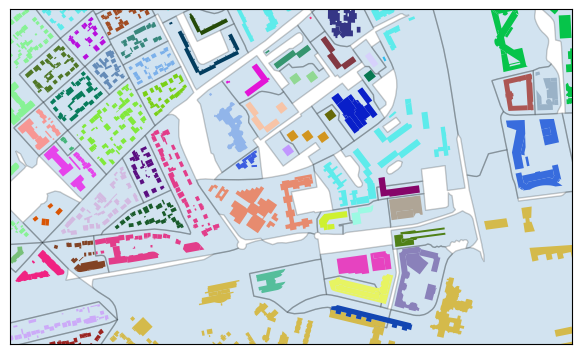

In [9]:
# 🔴 Partition the building according to the network structure
partition = cg.partition_networks(build['base_building'], list_generalized[-1])

partition_gdf = gp.GeoDataFrame(geometry=partition[-1])

# Setting up the map
fig = plt.figure(figsize=(SCREEN['1:7500']))
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)	
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)	

partition_gdf.plot(ax=ax, alpha = 0.2, edgecolor = 'black')
with progressbar.ProgressBar(max_value=len(partition[0]),widgets=widgets) as bar:
    for i in range(len(partition[0])):
        gdf = build['base_building'].copy()
        gdf = gdf.iloc[partition[0][i]]
        gdf.plot(ax=ax,color = (np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))
        bar.update(i)

💬 Partitioning is an **important** step when generalizing **big** dataset, since it speeds up processing.

**2.3.2'/** Code details on partition_networks algorithm

In [ ]:
partition = cg.partition_networks(build['base_building'], list_generalized[-1]) #using the Cartagen function on
#gdf containing building, and gdf containing roads

#the output is a list of two elements. First one is a list of list. Each list of this list 
#represent a face of the network and contains building indexes. 
#The second element of the list is a list of geometries of the faces

partition_gdf = gp.GeoDataFrame(geometry=partition[-1]) #using the last element of the list to build a gdf

# Setting up the map
fig = plt.figure(figsize=(SCREEN['1:7500']))
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)

partition_gdf.plot(ax=ax, alpha = 0.2, edgecolor = 'black') #display the faces
for i in range(len(partition[0])): #for each network face
    gdf = build['base_building'].copy()
    gdf = gdf.iloc[partition[0][i]] #filter the building gdf according to the indexes contained in the current face
    gdf.plot(ax=ax,color = (np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))

**2.3.3/** 🔴 Transforming buildings into built up area with the 'morphological_amalgamation' algorithm

In [10]:
# 🔴 Transforming buildings into built up area with the 'morphological_amalgamation' algorithm

def ma(buffer, edge_length, symbology_on, scale = '1:7500'):
    
    # Setting up the map
    fig = plt.figure(figsize=(SCREEN[scale]))
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    with progressbar.ProgressBar(max_value=len(partition[0]),widgets=widgets) as bar:
        if symbology_on == True:
         
            gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])
            selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])    
            selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')

            selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col']) 

            selected_data['gdf_vegetation'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])

            selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])

            for i in range(len(partition[0])):
                gdf = build['base_building'].copy()
                gdf = gdf.iloc[partition[0][i]]
                
                try:
                    generalized = cg.morphological_amalgamation(list(gdf.geometry), buffer = buffer, edge_length = edge_length) 

                except: 
                    generalized = gdf.geometry

                generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
                generalized_gdf = generalized_gdf.reset_index(drop = True)
                build[f'boffet_{i}'] = generalized_gdf
                build[f'boffet_{i}'].plot(ax=ax, color = SYMBO_PARAM['residential_col'])
                bar.update(i)
                
            for j in reversed(range(2,7)):
                list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{j}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{j}']+1)
                list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{j}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{j}'], linewidth = SYMBO_PARAM[f'road_width_{j}'])
            
         
        
    
        else:
            for i in range(len(partition[0])):
                gdf = build['base_building'].copy()
                gdf = gdf.iloc[partition[0][i]]

                try:
                    generalized = cg.morphological_amalgamation(list(gdf.geometry), buffer = buffer, edge_length = edge_length) 
                except: 
                    generalized = gdf.geometry

                generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
                generalized_gdf = generalized_gdf.reset_index(drop = True)
                build[f'ma_{i}'] = generalized_gdf
                build[f'ma_{i}'].plot(ax=ax)
                bar.update(i)
                
ipywidgets.interact(ma, scale = ['1:25000','1:10000', '1:7500', '1:5000'], symbology_on = False, 
                        buffer = ipywidgets.IntSlider(value = 10, min = 0,max = 100,step = 1,continuous_update=False), 
                        edge_length = ipywidgets.IntSlider(value = 0, min = 0,max = 50,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=10, continuous_update=False, description='buffer'), IntSlider(value=0, c…

<function __main__.ma(buffer, edge_length, symbology_on, scale='1:7500')>

💬 Another way of transforming buildings into **built up area** is to use the **'boffet_area'** algorithm

**2.3.3'/** Code details on morphological_amalgamation algorithm

In [ ]:
geom = [] #creating empty list that will store geometries
for i in range(len(partition[0])): #for each group of partitionned buildings
    gdf = build['base_building'].copy() 
    gdf = gdf.iloc[partition[0][i]] #filter the gdf containing buildings to keep buildings in the current group

    try:
        generalized = cg.morphological_amalgamation(list(gdf.geometry), buffer = 19, edge_length = 2) 
        #trying to use the algorithm on a list of the geometry of the group of buildings         
    except: 
        generalized = gdf.geometry
        #if the operation fails, return the geometries of the buildings without transformations
         
    for poly in generalized:
        geom.append(poly) #filling the list with the geometries of the result for current group
     
 #configuring figure 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)
        
generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(geom)) #build a gdf from the result
generalized_gdf.plot(ax=ax)

**2.3.4/** 🔴 Transforming buildings into built up area with the 'boffet_area' algorithm

In [11]:
# 🔴 Transforming buildings into built up area with the 'boffet_area' algorithm

def boff_area(buffer, erosion, symbology_on, simplification_dist, scale = '1:7500'):

    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    scalebar = AnchoredSizeBar(ax.transData,
                                    250,  
                                    '250 m',  
                                    'lower left',  
                                    pad=0.5,
                                    color='black',
                                    frameon=True,
                                    size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    with progressbar.ProgressBar(max_value=len(partition[0]),widgets=widgets) as bar:
        if symbology_on == True: 
            gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])
            count = -1
            for i in range(len(partition[0])):
                gdf = build['base_building'].copy()
                gdf = gdf.iloc[partition[0][i]]

                try:
                    generalized = cg.boffet_areas(gdf.geometry, buffer = buffer,  erosion = erosion, simplification_distance = simplification_dist)
                except: 
                    generalized = gdf.geometry  
                generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
                generalized_gdf.plot(ax=ax, color = SYMBO_PARAM['residential_col'])
                build[f'boffet_{i}'] = generalized_gdf
            
                bar.update(i)    
            selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])
            selected_data['gdf_vegetation'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])
            selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])

            for i in reversed(range(2,7)):
                list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
                list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])

        else:    
            for i in range(len(partition[0])):
                gdf = build['base_building'].copy()
                gdf = gdf.iloc[partition[0][i]]
                try:
                    generalized = cg.boffet_areas(gdf.geometry, buffer = buffer,  erosion = erosion, simplification_distance = simplification_dist)
                except: 
                    generalized = gdf.geometry  
                generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
                generalized_gdf.plot(ax=ax)
                build[f'boffet_{i}'] = generalized_gdf
                bar.update(i)
                
ipywidgets.interact(boff_area, buffer = ipywidgets.IntSlider(value = 8, min=0, max=100, step=1,  continuous_update=False),
                               erosion = ipywidgets.FloatSlider(min=0.1, max=100, step=1, continuous_update=False), 
                               simplification_dist = ipywidgets.IntSlider(min=1, max=100, step=1, continuous_update=False,style= {'description_width': 'initial'}),
                               scale = ['1:25000','1:10000', '1:7500', '1:5000'],
                               symbology_on = False) 

interactive(children=(IntSlider(value=8, continuous_update=False, description='buffer'), FloatSlider(value=0.1…

<function __main__.boff_area(buffer, erosion, symbology_on, simplification_dist, scale='1:7500')>

💬 In this case we use the **boffet_area** algorithm directly to generalize our buildings. Note that this algorithm was firstly design to **separate** rural and urban area **prior** to other generalisation processes. 

**2.3.4'/** Code details on boffet_area algorithm

In [ ]:
geom = [] #creating empty list that will store geometries
for i in range(len(partition[0])): #for each group of partitionned buildings
    gdf = build['base_building'].copy() 
    gdf = gdf.iloc[partition[0][i]] #filter the gdf containing buildings to keep buildings in the current group

    try:
        generalized = cg.boffet_areas(gdf.geometry, buffer = 8,  erosion = 20, simplification_distance = 1)
        #trying to use the algorithm on the geometry of the group of buildings         
    except: 
        generalized = gdf.geometry
        #if the operation fails, return the geometries of the buildings without transformations
         
    for poly in generalized:
        geom.append(poly) #filling the list with the geometries of the result for current group
     
 #configuring figure 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)
        
generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(geom)) #build a gdf from the result
generalized_gdf.plot(ax=ax)

**2.3.5/** 🔴 Removing too small areas 

In [12]:
# 🔴 Removing too small areas 
def rm_small(area_threshold, datas=1, scale = '1:7500'):

    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    with progressbar.ProgressBar(max_value=len(partition[0]),widgets=widgets) as bar:
        if datas == 1 and 'ma_0' in build:
            build['red_gen'] = []  

            for i in range(len(partition[0])):

                for j in range(len(build[f'ma_{i}'])):
                    build[f'ma_{i}'].loc[j,'area'] = build[f'ma_{i}'].loc[j,'geometry'].area 
                build[f'red_gen_{i}'] = build[f'ma_{i}'][(build[f'ma_{i}'].area > area_threshold)] 
                build[f'red_gen_{i}'].plot(ax=ax)
                build['red_gen'].append(build[f'red_gen_{i}'])
                bar.update(i)
            build['red_gen'] = gp.GeoDataFrame(pd.concat(build['red_gen'], ignore_index=True))

        elif datas == 2 and 'boffet_0' in build:
            build['red_gen'] = [] 
            for i in range(len(partition[0])):
                for j in range(len(build[f'boffet_{i}'])):
                    build[f'boffet_{i}'].loc[j,'area'] = build[f'boffet_{i}'].loc[j,'geometry'].area

                build[f'red_gen_{i}'] = build[f'boffet_{i}'][(build[f'boffet_{i}'].area > area_threshold)]
                build[f'red_gen_{i}'].plot(ax=ax)    
                build['red_gen'].append(build[f'red_gen_{i}'])
                bar.update(i)
            build['red_gen'] = gp.GeoDataFrame(pd.concat(build['red_gen'], ignore_index=True))
        elif 'boffet_0' not in build and 'ma_0' not in build:
            print("You must perform \'morphological_amalgation\' or \'boffet_area\' before running this cell !")
        else:
            print("there is no data to display, try other input data")
ipywidgets.interact(rm_small, scale = ['1:25000','1:10000', '1:7500', '1:5000'], area_threshold = ipywidgets.IntSlider(value = 100, min = 0,max = 5000,step = 1,continuous_update=False),
                              datas = ipywidgets.Dropdown(options=[('Morphological amalgamation', 1), ('Boffet area', 2)], value=1, description='Input datas :',))


interactive(children=(IntSlider(value=100, continuous_update=False, description='area_threshold', max=5000), D…

<function __main__.rm_small(area_threshold, datas=1, scale='1:7500')>

💬 This selection depending on the area value of each feature is not part of an algorithm in CartAGen : we simply use Geopandas' functions and methods to do that.

**2.3.5/** 🔴 Display results

In [ ]:
# 🔴 Display results    

def bf_af_3(scale='1:7500'):
    fig = plt.figure(figsize=SCREEN[scale])
    ax1 = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    plt.title("Before")	
    scalebar = AnchoredSizeBar(ax1.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax1.add_artist(scalebar)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    
    fig2 = plt.figure(figsize=SCREEN[scale])
    ax2 = fig2.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    plt.title("After")	
    scalebar = AnchoredSizeBar(ax2.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax2.add_artist(scalebar)	
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)	
    with progressbar.ProgressBar(max_value=len(partition[0]),widgets=widgets) as bar:
        if scale == '1:25000':
            plt.subplots_adjust(hspace=0)


        for i in reversed(range(2,7)):
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)

            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])


            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)

            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])

        for i in range(1):
            gdf_bckgrnd.plot(ax=ax2, color = SYMBO_PARAM['bckgrnd_col'])

            gdf_bckgrnd.plot(ax=ax1, color = SYMBO_PARAM['bckgrnd_col'])


            for j in range(len(partition[0])): 
                build[f'red_gen_{j}'].plot(ax = ax2, color = SYMBO_PARAM['residential_col'])
                bar.update(j)

            selected_data['gdf_trainline'].plot(ax=ax1, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])

            selected_data['gdf_trainline'].plot(ax=ax2, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])


            col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                                [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])       
            selected_data['gdf_building'].plot(ax=ax1, column = 'usage_1', cmap = col_buildings)


            selected_data['gdf_sportfield'].plot(ax=ax1, color = SYMBO_PARAM['sports_field_col'])

            selected_data['gdf_sportfield'].plot(ax=ax2, color = SYMBO_PARAM['sports_field_col'])


            selected_data['gdf_vegetation'].plot(ax=ax1, color = SYMBO_PARAM['vegetation_col'])

            selected_data['gdf_vegetation'].plot(ax=ax2, color = SYMBO_PARAM['vegetation_col'])


            selected_data['gdf_water'].plot(ax=ax1, color = SYMBO_PARAM['water_col'])

            selected_data['gdf_water'].plot(ax=ax2, color = SYMBO_PARAM['water_col'])


            selected_data['gdf_commune'].plot(ax=ax1, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))

            selected_data['gdf_commune'].plot(ax=ax2, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))

           
ipywidgets.interact(bf_af_3, scale = ['1:25000','1:10000', '1:7500', '1:5000'])

💬 Let's try a **less** generalized render, with both **merged** bulidings areas and **individual** buildings :

**2.3.6/** 🟠 Define area threshold between 'big' and 'small' buildings

In [ ]:
# 🟠 Define area threshold between 'big' and 'small' buildings

def area_build(area_tshld, scale = '1:7500'):
    global SCREEN
    global build

    build['small'] = []
    build['big'] = []
    with progressbar.ProgressBar(max_value=len(build['base_building'].geometry),widgets=widgets) as bar:
        for i in range(len(build['base_building'])):
            if build['base_building'].geometry[i].area <= area_tshld:
                build['small'].append(build['base_building'].geometry[i])
            else:
                build['big'].append(build['base_building'].iloc[i])
            bar.update(i)
        build['small'] = gp.GeoDataFrame({'geometry':gp.GeoSeries(build['small'])})
        build['big'] = gp.GeoDataFrame({'geometry':build['base_building'].geometry[(build['base_building'].area > area_tshld)],
                                       'usage_1':build['base_building'].usage_1[(build['base_building'].area > area_tshld)]})

        # Setting up the map
        fig = plt.figure(figsize=SCREEN[scale])
        ax = fig.add_subplot(111)
        plt.xlim(668198, 669411)
        plt.ylim(6860147, 6860869)		
        scalebar = AnchoredSizeBar(ax.transData,
                                            250,  
                                            '250 m',  
                                            'lower left',  
                                            pad=0.5,
                                            color='black',
                                            frameon=True,
                                            size_vertical=1)
        ax.add_artist(scalebar)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        build['small'].plot(ax=ax, color = '#36BA98')
        build['big'].plot(ax=ax, color = '#F4A261')

ipywidgets.interact(area_build, area_tshld = ipywidgets.IntSlider(value = 40, min=0, max=1500, step=1,  continuous_update=False), 
                                scale = ['1:25000','1:10000', '1:7500', '1:5000'])

💬 Again, this separation is performed using only Geopandas library. Thanks to it, we will be able to perform different types of transformation depending on **building size**. In the next cells, we want to **amalgamate** the small buildings, but not the big ones 

**2.3.7/** 🟠 Partition the datas for small buildings

In [ ]:
# 🟠 Partition the datas for small buildings
partition_small = cg.partition_networks(build['small'], list_generalized[-1])

partition_small_gdf = gp.GeoDataFrame(geometry=partition_small[-1])

# Setting up the map
fig = plt.figure(figsize=(SCREEN['1:7500']))
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)	
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)	

partition_small_gdf.plot(ax=ax, alpha = 0.2, edgecolor = 'black')
with progressbar.ProgressBar(max_value=len(partition_small[0]),widgets=widgets) as bar:
    for i in range(len(partition_small[0])):
        gdf = build['small'].copy()
        gdf = gdf.iloc[partition_small[0][i]]
        gdf.plot(ax=ax,color = (np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))
        bar.update(i)

💬 The process is the same as for the red 🔴 generalization workflow (see **2.3.2'**)

**2.3.8/** 🟠 Use the 'morphological_amalgamation' algorithm to merge small buildings

In [ ]:
# 🟠 Use the 'morphological_amalgamation' algorithm to merge small buildings

def morph_amal(buffer, edge_length, symbology_on, scale = '1:7500'):
    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    with progressbar.ProgressBar(max_value=len(partition_small[0]),widgets=widgets) as bar:
        if symbology_on == True:

            for i in range(1):
                gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])

                for i in range(len(partition_small[0])):
                    gdf = build['small'].copy()
                    gdf = gdf.iloc[partition_small[0][i]]
                    try:
                        generalized = cg.morphological_amalgamation(list(gdf.geometry), buffer = buffer, edge_length = edge_length) 
                    except: 
                        generalized = gdf.geometry
                    generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
                    generalized_gdf = generalized_gdf.reset_index(drop = True)
                    build[f'ma_small_{i}'] = generalized_gdf
                    build[f'ma_small_{i}'].plot(ax=ax, color = SYMBO_PARAM['residential_col'])
                    bar.update(i)
                selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])

                selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])

                selected_data['gdf_vegetation'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])

                selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')

                selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])

                col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                                [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])    
                build['big'].plot(ax=ax, column = 'usage_1', cmap = col_buildings)

            for i in reversed(range(2,7)):
                list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)

                list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])

        else:    
        
            for i in range(len(partition_small[0])):
                gdf = build['small'].copy()
                gdf = gdf.iloc[partition_small[0][i]]
                try:
                    generalized = cg.morphological_amalgamation(list(gdf.geometry), buffer = buffer, edge_length = edge_length) 
                except: 
                    generalized = gdf.geometry
                generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
                generalized_gdf = generalized_gdf.reset_index(drop = True)
                build[f'ma_small_{i}'] = generalized_gdf
                build[f'ma_small_{i}'].plot(ax=ax)
                bar.update(i)

ipywidgets.interact(morph_amal, buffer = ipywidgets.IntSlider(value = 10, min=0, max=50, step=1,  continuous_update=False),
                                                  edge_length = ipywidgets.IntSlider(min=1, max=50, step=1, continuous_update=False),
                                                  scale = ['1:25000','1:10000', '1:7500', '1:5000'],
                                                  symbology_on = False) 

💬 The process is the same as for the red 🔴 generalization workflow (see **2.3.3'**)

**2.3.9/** 🟠 Use the 'simplify_building' algorithm on big buildings

In [ ]:
# 🟠 Use the 'simplify_building' algorithm on big buildings
def build_simpl(edge_threshold, symbology_on, scale = '1:7500'):
    generalized = []
    with progressbar.ProgressBar(max_value=len(build['big']),widgets=widgets) as bar:
        for i in range(len(build['big'])):
            try:    
                generalized.append(cg.simplify_building(list(build['big'].geometry)[i], edge_threshold = edge_threshold))
            except:
                generalized.append(build['big'].geometry[i])
            bar.update(i)
        generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
        build['simplified'] = generalized_gdf

        # Setting up the map
        fig = plt.figure(figsize=SCREEN[scale])
        ax = fig.add_subplot(111)
        plt.xlim(668198, 669411)
        plt.ylim(6860147, 6860869)		
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        if symbology_on == True:

            for i in range(1):
                gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])

                generalized_gdf.plot(ax=ax, color = SYMBO_PARAM['residential_col'])

                selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])

                selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')

                selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])

                selected_data['gdf_vegetation'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])

                selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])

                for j in range(len(partition_small[0])):
                    build[f'ma_small_{j}'].plot(ax=ax, color = SYMBO_PARAM['residential_col'])

            for i in reversed(range(2,7)):
                list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)

                list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])

        else:    

            generalized_gdf.plot(ax=ax, color = "grey")


ipywidgets.interact(build_simpl, edge_threshold = ipywidgets.FloatSlider(min=0.0, max=50, step=1, continuous_update=False),
                                                  scale = ['1:25000','1:10000', '1:7500', '1:5000'],
                                                  symbology_on = False) 

**2.3.9'/** Code details on 'simplify_building' algorithm

In [ ]:
simpl_build = [] #list to store the geometries of simplified buildings
for i in range(len(build['big'])): #itering on each building of the gdf
    try:    
        simpl_build.append(cg.simplify_building(list(build['big'].geometry)[i], edge_threshold = 10)) 
        #apply the algorithm...
    except:
        simpl_build.append(build['big'].geometry[i])
        #..or return the geometry of the building without transformation
        
simpl_build_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(simpl_build)) #transform the list into gdf to plot it
simpl_build_gdf.plot()

**2.3.10/** 🟠 Removing too small polygons

In [ ]:
# 🟠 Removing too small polygons
def rm_small_2(area_threshold, scale = '1:7500'):

    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    with progressbar.ProgressBar(max_value=len(build['simplified'])+len(partition_small[0]),widgets=widgets) as bar:
        for i in range(len(build['simplified'])):
            build['simplified'].loc[i,'area'] = build['simplified'].loc[i,'geometry'].area
            
        build['bb'] = build['simplified'][(build['simplified'].area > area_threshold)]
        build['bb'].plot(ax=ax)    
        
        build['ma_small'] = []
        for i in range(len(partition_small[0])):
            for j in range(len(build[f'ma_small_{i}'])):
                build[f'ma_small_{i}'].loc[j,'area'] = build[f'ma_small_{i}'].loc[j,'geometry'].area
            build['ma_small'].append(build[f'ma_small_{i}'][(build[f'ma_small_{i}'].area > area_threshold)])
            bar.update(i)
        build['ma_small'] = gp.GeoDataFrame(pd.concat(build['ma_small'], ignore_index=True))
        build['ma_small'].plot(ax=ax) 

ipywidgets.interact(rm_small_2,scale = ['1:25000','1:10000', '1:7500', '1:5000'], 
                               area_threshold = ipywidgets.IntSlider(value = 100, min = 0,max = 5000,step = 1,continuous_update=False))

💬 Again, this filter is performed using only Geopandas library.

**2.3.11/** 🟠 Display results

In [ ]:
# 🟠 Display results    

def bf_af_3(scale='1:7500'):
    fig = plt.figure(figsize=SCREEN[scale])
    ax1 = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    plt.title("Before")	
    scalebar = AnchoredSizeBar(ax1.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax1.add_artist(scalebar)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    
    fig2 = plt.figure(figsize=SCREEN[scale])
    ax2 = fig2.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    plt.title("After")
    scalebar = AnchoredSizeBar(ax2.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax2.add_artist(scalebar)	
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)	
    
    if scale == '1:25000':
        plt.subplots_adjust(hspace=0)
        
    
   
    with progressbar.ProgressBar(max_value=5,widgets=widgets) as bar:    
        for i in range(1):
            gdf_bckgrnd.plot(ax=ax2, color = SYMBO_PARAM['bckgrnd_col'])

            gdf_bckgrnd.plot(ax=ax1, color = SYMBO_PARAM['bckgrnd_col'])

            bar.update(1)

            build['ma_small'].plot(ax = ax2, color = SYMBO_PARAM['residential_col'])

            bar.update(2)
            build['bb'].plot(ax= ax2, color = SYMBO_PARAM['residential_col'])   
            bar.update(3)

            col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                                [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])       
            selected_data['gdf_building'].plot(ax=ax1, column = 'usage_1', cmap = col_buildings)

            bar.update(4)
            selected_data['gdf_trainline'].plot(ax=ax1, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])

            selected_data['gdf_trainline'].plot(ax=ax2, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])


            selected_data['gdf_sportfield'].plot(ax=ax1, color = SYMBO_PARAM['sports_field_col'])

            selected_data['gdf_sportfield'].plot(ax=ax2, color = SYMBO_PARAM['sports_field_col'])


            selected_data['gdf_vegetation'].plot(ax=ax1, color = SYMBO_PARAM['vegetation_col'])

            selected_data['gdf_vegetation'].plot(ax=ax2, color = SYMBO_PARAM['vegetation_col'])


            selected_data['gdf_water'].plot(ax=ax1, color = SYMBO_PARAM['water_col'])

            selected_data['gdf_water'].plot(ax=ax2, color = SYMBO_PARAM['water_col'])


            selected_data['gdf_commune'].plot(ax=ax1, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))

            selected_data['gdf_commune'].plot(ax=ax2, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))


        for i in reversed(range(2,7)):
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)

            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
        

            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)

            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
        bar.update(5)
           
ipywidgets.interact(bf_af_3, scale = ['1:25000','1:10000', '1:7500', '1:5000'])

💬 Let's explore another **workflow** for building generalisation that do **not** merges them (and thus gives a less generalized render). 

**2.3.12/** 🟡 Perform adaptative generalisation on each individual building using the AGENT model (🏗 work in progess...)

In [ ]:
# 🟡 Perform adaptative generalisation on each individual building (🏗 work in progess...)
#test_build = build['base_building'].iloc[0:150].copy()

#agents = []
#for index, building in test_build.iterrows():
    #agent = cg.BuildingAgent(building)
    # squareness = cg.BuildingSquarenessConstraint(agent, 3,angle_tolerance=50.0)
    #size = cg.BuildingSizeConstraint(agent, 1, min_area = 250, area_threshold= 80)
    #granularity = cg.BuildingGranularityConstraint(agent, 1, min_length=50.0)

    # agent.constraints.append(squareness)
    #agent.constraints.append(size)
    #agent.constraints.append(granularity)

    #agents.append(agent)
#cg.run_agents(agents)

#fig = plt.figure(figsize=(12,12))
#ax = build['base_building'].iloc[0:150].plot(color='blue')
#test_build.plot(ax=ax,color='red')

**2.3.13/** 🟡🟠 Displace buildings that overlaps (or is to close from) roads and other buildings

In [ ]:
# 🟡🟠 Displace buildings that overlaps (or is to close from) roads and other buildings
#configuring figure 
fig = plt.figure(figsize=SCREEN['1:7500'])
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

partition = cg.partition_networks(build['bb'], list_generalized[-1])
gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col']) 

with progressbar.ProgressBar(max_value=len(partition[0]),widgets=widgets) as bar:
    for i in range(len(partition[0])):
        gdf = build['bb'].copy()
        gdf = gdf.iloc[partition[0][i]]
        build['b_dis'] = cg.random_displacement(gdf, networks=[list_generalized[-1]], polygon_distance=10.0, 
                                                         network_distance=10.0, max_trials=25, max_displacement=10.0)
        build['b_dis'].plot(ax=ax, color= SYMBO_PARAM['residential_col']) 
        bar.update(i)
    
#adding other map features  
build['ma_small'].plot(ax = ax, color = SYMBO_PARAM['residential_col'])  
selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])
selected_data['gdf_vegetation'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])
selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])
selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))
for i in reversed(range(2,7)):
    list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
    list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])


💬 Buildings that are close to eachother are sometimes part of the **same facility** (i.e main building + annexes). Thus, displacing those buildings can be **irrealistic**. 

Also, note that using **partitionning** techniques highly accelerate processing for this algorithm (**21 times** faster in my case).

**2.3.13'/** Code details on random_displacement algorithm

In [ ]:
displaced = cg.random_displacement(build['bb'], networks=[list_generalized[-1]], polygon_distance=10.0, 
                                             network_distance=10.0, max_trials=25, max_displacement=10.0,
                                             network_partitioning=[list_generalized[-1]])

#configuring figure 
fig = plt.figure(figsize=SCREEN['1:7500'])
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)

list_generalized[-1].plot(ax=ax)
displaced.plot(ax=ax)

### **2.4/** Other features
To **finalize** this generalisation workflow, let's generalize the remaining features that need it

**2.4.1/** 🟡🟠🔴 Simplify the shape of the vegetation areas by fullfilling it's thin parts

In [13]:
# 🟡🟠🔴 Simplify the shape of the vegetation areas by fullfilling it's thin parts
def close_veget(size, quad_segs, scale = '1:7500'):
    build['vegetation'] = selected_data['gdf_vegetation'].copy()
    with progressbar.ProgressBar(max_value=len(build['vegetation']),widgets=widgets) as bar:
        for i in range(len(build['vegetation'])):
            build['vegetation'].loc[i,'geometry'] = cg.close_polygon(build['vegetation'].loc[i,'geometry'], size =size, quad_segs = quad_segs)
            bar.update(i)

     # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    build['vegetation'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])

ipywidgets.interact(close_veget, scale = ['1:25000','1:10000', '1:7500', '1:5000'],
                                 size = ipywidgets.IntSlider(value = 1, min=0, max=40, step=1, continuous_update=False),
                                 quad_segs = ipywidgets.IntSlider(value = 1, min=0, max=40, step=1, continuous_update=False))

interactive(children=(IntSlider(value=1, continuous_update=False, description='size', max=40), IntSlider(value…

<function __main__.close_veget(size, quad_segs, scale='1:7500')>

**2.4.1'/** Code details on "close_polygon" algorithm

In [ ]:
veget_simpl = selected_data['gdf_vegetation'].copy() # copying the gdf containing vegetation
    
for i in range(len(build['vegetation'])): #itering on the features of this gdf
    veget_simpl.loc[i,'geometry'] = cg.close_polygon(veget_simpl.loc[i,'geometry'], 
                                            size =10, quad_segs = 8)
veget_simpl.plot()

**2.4.2/** 🟡🟠🔴 Simplify the shape of the vegetation areas by reducing the number of vertex (Douglas_Peucker algorithm)

In [15]:
# 🟡🟠🔴 Simplify the shape of the vegetation areas by reducing the number of vertex (Douglas_Peucker algorithm)
def simpl_veget(threshold, symbology_on, preserve_topology=True, gen_type = 1,scale = '1:7500'):
    global SCREEN
    global SYMBO_PARAM
    global build
   
    generalized = []
    with progressbar.ProgressBar(max_value=len(build['vegetation']),widgets=widgets) as bar:
        for i in range(len(build['vegetation'])):
            generalized.append(cg.douglas_peucker(list(build['vegetation'].geometry)[i], threshold = threshold, preserve_topology = preserve_topology))
            bar.update(i)
    generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
    build['vegetation_simpl'] = generalized_gdf
    
    for i in range(len(build['vegetation_simpl'])):
        build['vegetation_simpl'].loc[i,'area'] = build['vegetation_simpl'].loc[i,'geometry'].area

    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    scalebar = AnchoredSizeBar(ax.transData,
                                    250,  
                                    '250 m',  
                                    'lower left',  
                                    pad=0.5,
                                    color='black',
                                    frameon=True,
                                    size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])
    
    if symbology_on == True:  
        if gen_type == 1 and 'red_gen' in build:
            build['red_gen'].plot(ax=ax, color=SYMBO_PARAM['residential_col'])
        elif gen_type == 2 and 'bb' in build:  
            build['bb'].plot(ax=ax, color=SYMBO_PARAM['residential_col'])
            build['ma_small'].plot(ax=ax, color=SYMBO_PARAM['residential_col'])
        elif gen_type == 3 and 'yellow' in build: 
            build['yellow'].plot(ax=ax, color=SYMBO_PARAM['residential_col'])
        
        for i in range(1):
         
            generalized_gdf.plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])
       
            selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
           
            selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
   
            selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])
       
            selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])
         
        for i in reversed(range(2,7)):
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
      
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
        
         
    else:    
    
        generalized_gdf.plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])
     

    
ipywidgets.interact(simpl_veget, preserve_topology = True, 
                                                  threshold = ipywidgets.IntSlider(min=0, max=40, step=1, continuous_update=False),
                                                  scale = ['1:25000','1:10000', '1:7500', '1:5000'],
                                                  symbology_on = False,
                                                  gen_type = ipywidgets.Dropdown(options=[('Red', 1), ('Orange', 2), ('Yellow', 3)], style={'description_width': 'initial'},value=1, description='Generalisation workflow :')) 

interactive(children=(IntSlider(value=0, continuous_update=False, description='threshold', max=40), Checkbox(v…

<function __main__.simpl_veget(threshold, symbology_on, preserve_topology=True, gen_type=1, scale='1:7500')>

💬 Douglas-Peucker algorithm **remove** some vertex of the given shapes. It tends to retain the most important vertex for the shape **structure**. 

**2.4.2'** Code details on douglas_peucker algorithm

In [ ]:
simplified_shapes = []
for i in range(len(build['vegetation'])):
    simplified_shapes.append(cg.douglas_peucker(list(build['vegetation'].geometry)[i],
                                                            threshold = 10, preserve_topology = True))
            
simplified = gp.GeoDataFrame(geometry=gp.GeoSeries(simplified_shapes))

simplified.plot()

**2.4.3/** 🟡🟠🔴 Smooth the shape of the vegetation areas

In [16]:
# 🟡🟠🔴 Smooth the shape of the vegetation areas

def smooth_veget(sigma, sample,symbology_on, densify, gen_type=1, scale = '1:7500'):
    global SCREEN
    global SYMBO_PARAM
    global build
   
    generalized = []
    with progressbar.ProgressBar(max_value=len(build['vegetation']),widgets=widgets) as bar:
        for i in range(len(build['vegetation'])):
            try:
                generalized.append(cg.gaussian_smoothing(build['vegetation'].geometry[i], sigma = sigma, sample = sample, densify = densify))
            except:
                generalized.append(build['vegetation'].geometry[i])
            bar.update(i)
    generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
    build['vegetation_smooth'] = generalized_gdf
    for i in range(len(build['vegetation_smooth'])):
        build['vegetation_smooth'].loc[i,'area'] = build['vegetation_smooth'].loc[i,'geometry'].area

    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    scalebar = AnchoredSizeBar(ax.transData,
                                    250,  
                                    '250 m',  
                                    'lower left',  
                                    pad=0.5,
                                    color='black',
                                    frameon=True,
                                    size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])

    if symbology_on == True:
        if gen_type == 1 and 'red_gen' in build:
            build['red_gen'].plot(ax=ax, color=SYMBO_PARAM['residential_col'])
        elif gen_type == 2 and 'bb' in build:  
            build['bb'].plot(ax=ax, color=SYMBO_PARAM['residential_col'])
            build['ma_small'].plot(ax=ax, color=SYMBO_PARAM['residential_col'])
        elif gen_type == 3 and 'yellow' in build: 
            build['yellow'].plot(ax=ax, color=SYMBO_PARAM['residential_col'])
    
        for i in range(1):
            
            generalized_gdf.plot(ax=ax,color = SYMBO_PARAM['vegetation_col'])
        
            selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
             
            selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
          
            selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])
            
            selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])
           
        for i in reversed(range(2,7)):
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
                
    else:    
        generalized_gdf.plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])
       
    
ipywidgets.interact(smooth_veget, sigma = ipywidgets.IntSlider(min=0, max=50, step=1, continuous_update=False),
                                 scale = ['1:25000','1:10000', '1:7500', '1:5000'],
                                 sample = ipywidgets.IntSlider(min=0, max=50, step=1, continuous_update=False),
                                densify = True,
                                symbology_on = False,
                                gen_type = ipywidgets.Dropdown(options=[('Red', 1), ('Orange', 2), ('Yellow', 3)], style={'description_width': 'initial'},value=1, description='Generalisation workflow :')) 

interactive(children=(IntSlider(value=0, continuous_update=False, description='sigma', max=50), IntSlider(valu…

<function __main__.smooth_veget(sigma, sample, symbology_on, densify, gen_type=1, scale='1:7500')>

💬 If you do not like the **"sharp"** aspect of the vegetation area after the use of Douglas-Peucker algorithm, you can run this **smoothing aglorithm** instead. It gives a **"rounder"** result.

**2.4.3'/** Code details on 'gaussian_smoothing' algorithm 

In [ ]:
smoothed_shapes = []
for i in range(len(build['vegetation'])): #for each vegetation feature
    try:
        smoothed_shapes.append(cg.gaussian_smoothing(build['vegetation'].geometry[i], sigma = 8, sample = 8, densify = True)) 
    except:
        smoothed_shapes.append(build['vegetation'].geometry[i])        

smoothed = gp.GeoDataFrame(geometry=gp.GeoSeries(smoothed_shapes))

smoothed.plot()

**2.4.4/** 🟡🟠🔴 Remove too small areas 

In [17]:
# 🟡🟠🔴 Remove too small areas 

def small_veg(area_threshold, vegetation=1, scale = '1:7500'):
    global build 
    
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    def multipolygon_to_polygon(geom): # function that transform MultiPolygon geometry to Polygon
        if isinstance(geom, MultiPolygon):
            return geom.geoms[0]
        return geom

    if vegetation == 1:
    
     
        build['veget_ok'] = build['vegetation_smooth'][(build['vegetation_smooth'].area > area_threshold)]
        build['veget_ok'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])

    elif  vegetation == 2:
        for i in range(len(build['vegetation_simpl'])):
            build['vegetation_simpl'].loc[i,'area'] = build['vegetation_simpl'].loc[i,'geometry'].area
        build['veget_ok'] = build['vegetation_simpl'][(build['vegetation_simpl'].area > area_threshold)]
        build['veget_ok'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])

    else:
        build['vegetation'] = selected_data['gdf_vegetation'].copy()
        for i in range(len(build['vegetation'])):
            build['vegetation'].loc[i,'area'] = build['vegetation'].loc[i,'geometry'].area
        build['veget_ok'] = build['vegetation'][(build['vegetation'].area > area_threshold)]
        build['veget_ok'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])

ipywidgets.interact(small_veg, scale = ['1:25000','1:10000', '1:7500', '1:5000'],
 area_threshold = ipywidgets.IntSlider(min=0, max=1000, step=1, continuous_update=False),
 vegetation = ipywidgets.Dropdown(options=[('Smoothed', 1), ('Simplified', 2), ('Not generalized', 3)], style={'description_width': 'initial'},value=1, description='Vegetation'))

interactive(children=(IntSlider(value=0, continuous_update=False, description='area_threshold', max=1000), Dro…

<function __main__.small_veg(area_threshold, vegetation=1, scale='1:7500')>

**2.4.5/** 🟡🟠🔴 Display results

In [ ]:
# Display results 
def bf_af_4(gen_type =1, scale = '1:7500'):
    if gen_type == 2 and 'ma_small' in build:
        fig = plt.figure(figsize=(SCREEN[scale]))
        ax1 = fig.add_subplot(111)
        plt.xlim(668198, 669411)
        plt.ylim(6860147, 6860869)	
        plt.title("Before")	
        scalebar = AnchoredSizeBar(ax1.transData,
                                            250,  
                                            '250 m',  
                                            'lower left',  
                                            pad=0.5,
                                            color='black',
                                            frameon=True,
                                            size_vertical=1)
        ax1.add_artist(scalebar)
        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)
        
        fig2 = plt.figure(figsize=SCREEN[scale])
        ax2 = fig2.add_subplot(111)
        plt.xlim(668198, 669411)
        plt.ylim(6860147, 6860869)
        plt.title("After")	
        scalebar = AnchoredSizeBar(ax2.transData,
                                            250,  
                                            '250 m',  
                                            'lower left',  
                                            pad=0.5,
                                            color='black',
                                            frameon=True,
                                            size_vertical=1)
        ax2.add_artist(scalebar)	
        ax2.axes.get_xaxis().set_visible(False)
        ax2.axes.get_yaxis().set_visible(False)	
        
        gdf_bckgrnd.plot(ax=ax2, color = SYMBO_PARAM['bckgrnd_col'])
        gdf_bckgrnd.plot(ax=ax1, color = SYMBO_PARAM['bckgrnd_col'])
            
        build['ma_small'].plot(ax = ax2, color = SYMBO_PARAM['residential_col']) 
        build['bb'].plot(ax = ax2, color = SYMBO_PARAM['residential_col'])     

        col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                                [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])       
        build['base_building'].plot(ax=ax1, column = 'usage_1', cmap = col_buildings)
            

        selected_data['gdf_trainline'].plot(ax=ax1, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
        selected_data['gdf_trainline'].plot(ax=ax2, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])    
        
        selected_data['gdf_sportfield'].plot(ax=ax1, color = SYMBO_PARAM['sports_field_col']) 
        selected_data['gdf_sportfield'].plot(ax=ax2, color = SYMBO_PARAM['sports_field_col'])
        
        selected_data['gdf_vegetation'].plot(ax=ax1, color = SYMBO_PARAM['vegetation_col']) 
        build['veget_ok'].plot(ax=ax2, color = SYMBO_PARAM['vegetation_col'])
            
        selected_data['gdf_water'].plot(ax=ax1, color = SYMBO_PARAM['water_col'])
        selected_data['gdf_water'].plot(ax=ax2, color = SYMBO_PARAM['water_col'])
            
        selected_data['gdf_commune'].plot(ax=ax1, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))
        selected_data['gdf_commune'].plot(ax=ax2, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))
            
        for i in reversed(range(2,7)):
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)

            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
          

    elif gen_type == 1 and 'red_gen' in build:
        fig = plt.figure(figsize=(SCREEN[scale]))
        ax1 = fig.add_subplot(111)
        plt.xlim(668198, 669411)
        plt.ylim(6860147, 6860869)	
        plt.title("Before")	
        scalebar = AnchoredSizeBar(ax1.transData,
                                            250,  
                                            '250 m',  
                                            'lower left',  
                                            pad=0.5,
                                            color='black',
                                            frameon=True,
                                            size_vertical=1)
        ax1.add_artist(scalebar)
        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)
        
        fig2 = plt.figure(figsize=SCREEN[scale])
        ax2 = fig2.add_subplot(111)
        plt.xlim(668198, 669411)
        plt.ylim(6860147, 6860869)
        plt.title("After")	
        scalebar = AnchoredSizeBar(ax2.transData,
                                            250,  
                                            '250 m',  
                                            'lower left',  
                                            pad=0.5,
                                            color='black',
                                            frameon=True,
                                            size_vertical=1)
        ax2.add_artist(scalebar)	
        ax2.axes.get_xaxis().set_visible(False)
        ax2.axes.get_yaxis().set_visible(False)	
        
        gdf_bckgrnd.plot(ax=ax2, color = SYMBO_PARAM['bckgrnd_col'])
        gdf_bckgrnd.plot(ax=ax1, color = SYMBO_PARAM['bckgrnd_col'])
            
        build['red_gen'].plot(ax = ax2, color = SYMBO_PARAM['residential_col']) 
            
        col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                                [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])       
        build['base_building'].plot(ax=ax1, column = 'usage_1', cmap = col_buildings)
            

        selected_data['gdf_trainline'].plot(ax=ax1, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
        selected_data['gdf_trainline'].plot(ax=ax2, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])    
        
        selected_data['gdf_sportfield'].plot(ax=ax1, color = SYMBO_PARAM['sports_field_col']) 
        selected_data['gdf_sportfield'].plot(ax=ax2, color = SYMBO_PARAM['sports_field_col'])
        
        selected_data['gdf_vegetation'].plot(ax=ax1, color = SYMBO_PARAM['vegetation_col']) 
        build['veget_ok'].plot(ax=ax2, color = SYMBO_PARAM['vegetation_col'])
            
        selected_data['gdf_water'].plot(ax=ax1, color = SYMBO_PARAM['water_col'])
        selected_data['gdf_water'].plot(ax=ax2, color = SYMBO_PARAM['water_col'])
            
        selected_data['gdf_commune'].plot(ax=ax1, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))
        selected_data['gdf_commune'].plot(ax=ax2, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))
            
        for i in reversed(range(2,7)):
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
          
    elif gen_type == 3 and 'yellow' in build:
        fig = plt.figure(figsize=(SCREEN[scale]))
        ax1 = fig.add_subplot(111)
        plt.xlim(668198, 669411)
        plt.ylim(6860147, 6860869)	
        plt.title("Before")	
        scalebar = AnchoredSizeBar(ax1.transData,
                                            250,  
                                            '250 m',  
                                            'lower left',  
                                            pad=0.5,
                                            color='black',
                                            frameon=True,
                                            size_vertical=1)
        ax1.add_artist(scalebar)
        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)
        
        fig2 = plt.figure(figsize=SCREEN[scale])
        ax2 = fig2.add_subplot(111)
        plt.xlim(668198, 669411)
        plt.ylim(6860147, 6860869)
        plt.title("After")	
        scalebar = AnchoredSizeBar(ax2.transData,
                                            250,  
                                            '250 m',  
                                            'lower left',  
                                            pad=0.5,
                                            color='black',
                                            frameon=True,
                                            size_vertical=1)
        ax2.add_artist(scalebar)	
        ax2.axes.get_xaxis().set_visible(False)
        ax2.axes.get_yaxis().set_visible(False)	
        
        gdf_bckgrnd.plot(ax=ax2, color = SYMBO_PARAM['bckgrnd_col'])
        gdf_bckgrnd.plot(ax=ax1, color = SYMBO_PARAM['bckgrnd_col'])
            
        build['yellow'].plot(ax = ax2, color = SYMBO_PARAM['residential_col']) 
            
        col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                                [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])       
        build['base_building'].plot(ax=ax1, column = 'usage_1', cmap = col_buildings)
            

        selected_data['gdf_trainline'].plot(ax=ax1, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
        selected_data['gdf_trainline'].plot(ax=ax2, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])    
        
        selected_data['gdf_sportfield'].plot(ax=ax1, color = SYMBO_PARAM['sports_field_col']) 
        selected_data['gdf_sportfield'].plot(ax=ax2, color = SYMBO_PARAM['sports_field_col'])
        
        selected_data['gdf_vegetation'].plot(ax=ax1, color = SYMBO_PARAM['vegetation_col']) 
        build['veget_ok'].plot(ax=ax2, color = SYMBO_PARAM['vegetation_col'])
            
        selected_data['gdf_water'].plot(ax=ax1, color = SYMBO_PARAM['water_col'])
        selected_data['gdf_water'].plot(ax=ax2, color = SYMBO_PARAM['water_col'])
            
        selected_data['gdf_commune'].plot(ax=ax1, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))
        selected_data['gdf_commune'].plot(ax=ax2, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))
            
        for i in reversed(range(2,7)):
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
    else: 
        print("Buildings are not generalized, try selecting another generalisation workflow")

ipywidgets.interact(bf_af_4,scale = ['1:25000','1:10000', '1:7500', '1:5000'],
 gen_type = ipywidgets.Dropdown(options=[('Red', 1), ('Orange', 2), ('Yellow', 3)], style={'description_width': 'initial'},value=1, description='Generalisation workflow :'))
    

### **2.5/** Some example results (🏗 work in progess...)

💬 It is important to note that **perfect** worflow for cartographic generalisation **doesn't exist** : each algorithm have their **limits**, so there are often hand made **corections** to be made.

With that said, here are examples of render using **only** the techniques shown here, without corections. 
Not bad, right ?